In [ ]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import RandomizedSearchCV



In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EXL_EQ_2023_Dataset.csv',header=0,names=['PM2_5','NO','NO2','NOx','NH3','SO2','CO','Ozone','Benzene','Toluene','Temp','RH','WS','WD','SR','BP','AT','RF','TOT_RF','VWS','Eth_Benzene','Xylene','MP_Xylene','O_Xylene','CH4','City','State','Population_2021','Latitude','Longitude','Total_Length_Roads_2019','Length_National_Highways_2022','Railway_Route_2021','Forest_Cover_2021','Number_Factories_2020','Installed_Capacity_Power_2022_MW','Death_Rate_2020','CNG_ONLY','DIESEL','DIESEL_HYBRID','ELECTRIC_BOV','PETROL','PETROL_CNG','PETROL_HYBRID','Time_Periods'])

In [ ]:
df = df.set_index('Time_Periods')
df.index = pd.to_datetime(df.index)

#INITIAL CLEANING

In [ ]:
df_1 = df

In [ ]:
#Percentage of null value present
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).to_frame()

In [ ]:
# drop columns with null values % > 10%
df_1 = df_1.drop(['CH4','VWS','Temp','O_Xylene'
,'Xylene','BP' , 'Toluene'	,'MP_Xylene','Eth_Benzene','RH'],axis=1)

In [ ]:
# Function to change values that were numeric but the datatype was object
def transform(column):
  res = []
  for i in column:
      i = str(i)
      res.append(int(i.replace(',', '')))
  return res

In [ ]:

cat_to_numeric = ['CNG_ONLY', 'DIESEL', 'ELECTRIC_BOV', 'PETROL', 'PETROL_CNG', 'PETROL_HYBRID']

#Replace nan in objects
for i in cat_to_numeric:
  df_1[i]=df_1[i].fillna(0)

# To numeric
for i in cat_to_numeric:
  df_1[i] = transform(df_1[i])

In [ ]:
df_1.isnull().sum()

In [ ]:
#fill with nearest corresponding values
df_1=df_1.fillna(method = 'ffill')


In [ ]:
#drop electric_bov because this likely will not contribute much to the PM trend 
df_1 = df_1.drop('ELECTRIC_BOV',axis=1)

#drop all Demographic variables
df_1 = df_1.drop(['State','Population_2021','Latitude','Longitude','Total_Length_Roads_2019','Length_National_Highways_2022',
                  'Railway_Route_2021','Forest_Cover_2021','Number_Factories_2020','Installed_Capacity_Power_2022_MW','Death_Rate_2020'],axis=1)

In [ ]:
df_1 = df_1.dropna()

#Feature Engineering

In [ ]:
#Grouping vehicles based on the fuel used
df_1['vehicles_CNG'] =  df_1['CNG_ONLY'] + df_1['PETROL_CNG'] 
df_1['vehicles_DP'] = df_1['DIESEL'] +df_1['DIESEL_HYBRID'] +df_1['PETROL'] +df_1['PETROL_HYBRID'] 

In [ ]:
#dropping the redundant columns
df_1 = df_1.drop(['CNG_ONLY','DIESEL', 'DIESEL_HYBRID',  'PETROL', 'PETROL_CNG','PETROL_HYBRID'],axis=1)


In [ ]:
# Create time series features.
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

df_1 = create_features(df_1)

In [ ]:
#adding lag features - main idea is that the future PM2.5  trend may be to the previous PM2.5 value
def add_lags(df):
    target_map = df['PM2_5'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df
    
df_1 = add_lags(df_1)

#Decomposing the time series in:

*  **Seasonality** - does the data have a clear cyclical/periodic pattern?
*  **Trend** - does the data represent a general upward or downward slope?
*  **Noise** - what are the outliers or missing values that are not consistent with the rest of the data?



In [ ]:
df_GHZ = df_1[df_1['City']=='Ghaziabad']
df_GHZ = df_GHZ.drop('City',axis=1)

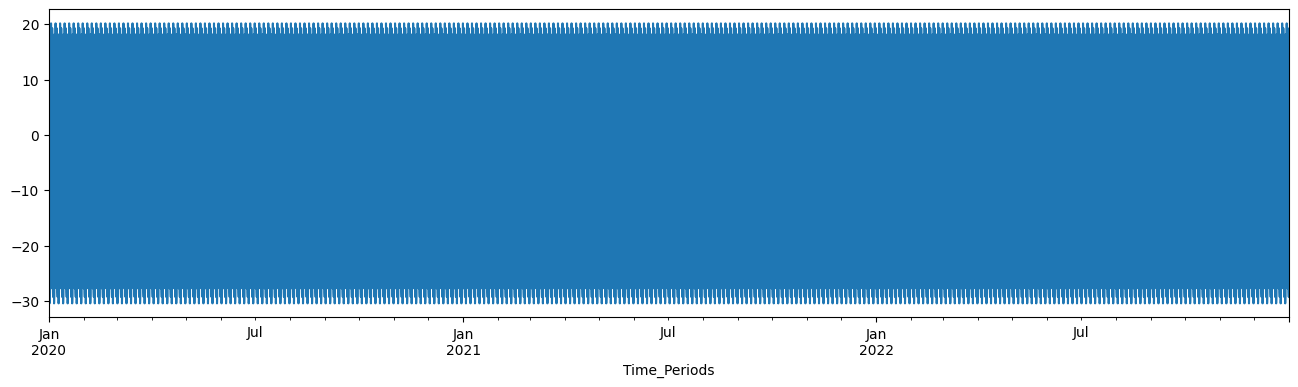

In [ ]:
import statsmodels.api as sm
from matplotlib import rcParams

decomposition = sm.tsa.seasonal_decompose(df_GHZ["PM2_5"])

rcParams["figure.figsize"] = 16, 4
decomposition.seasonal.plot();

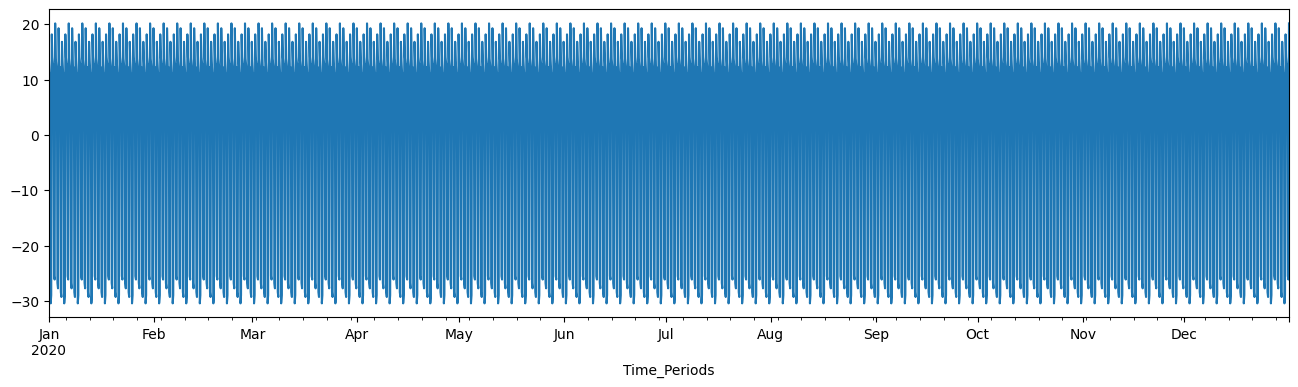

In [ ]:
decomposition.seasonal["2020":"2020"].plot();

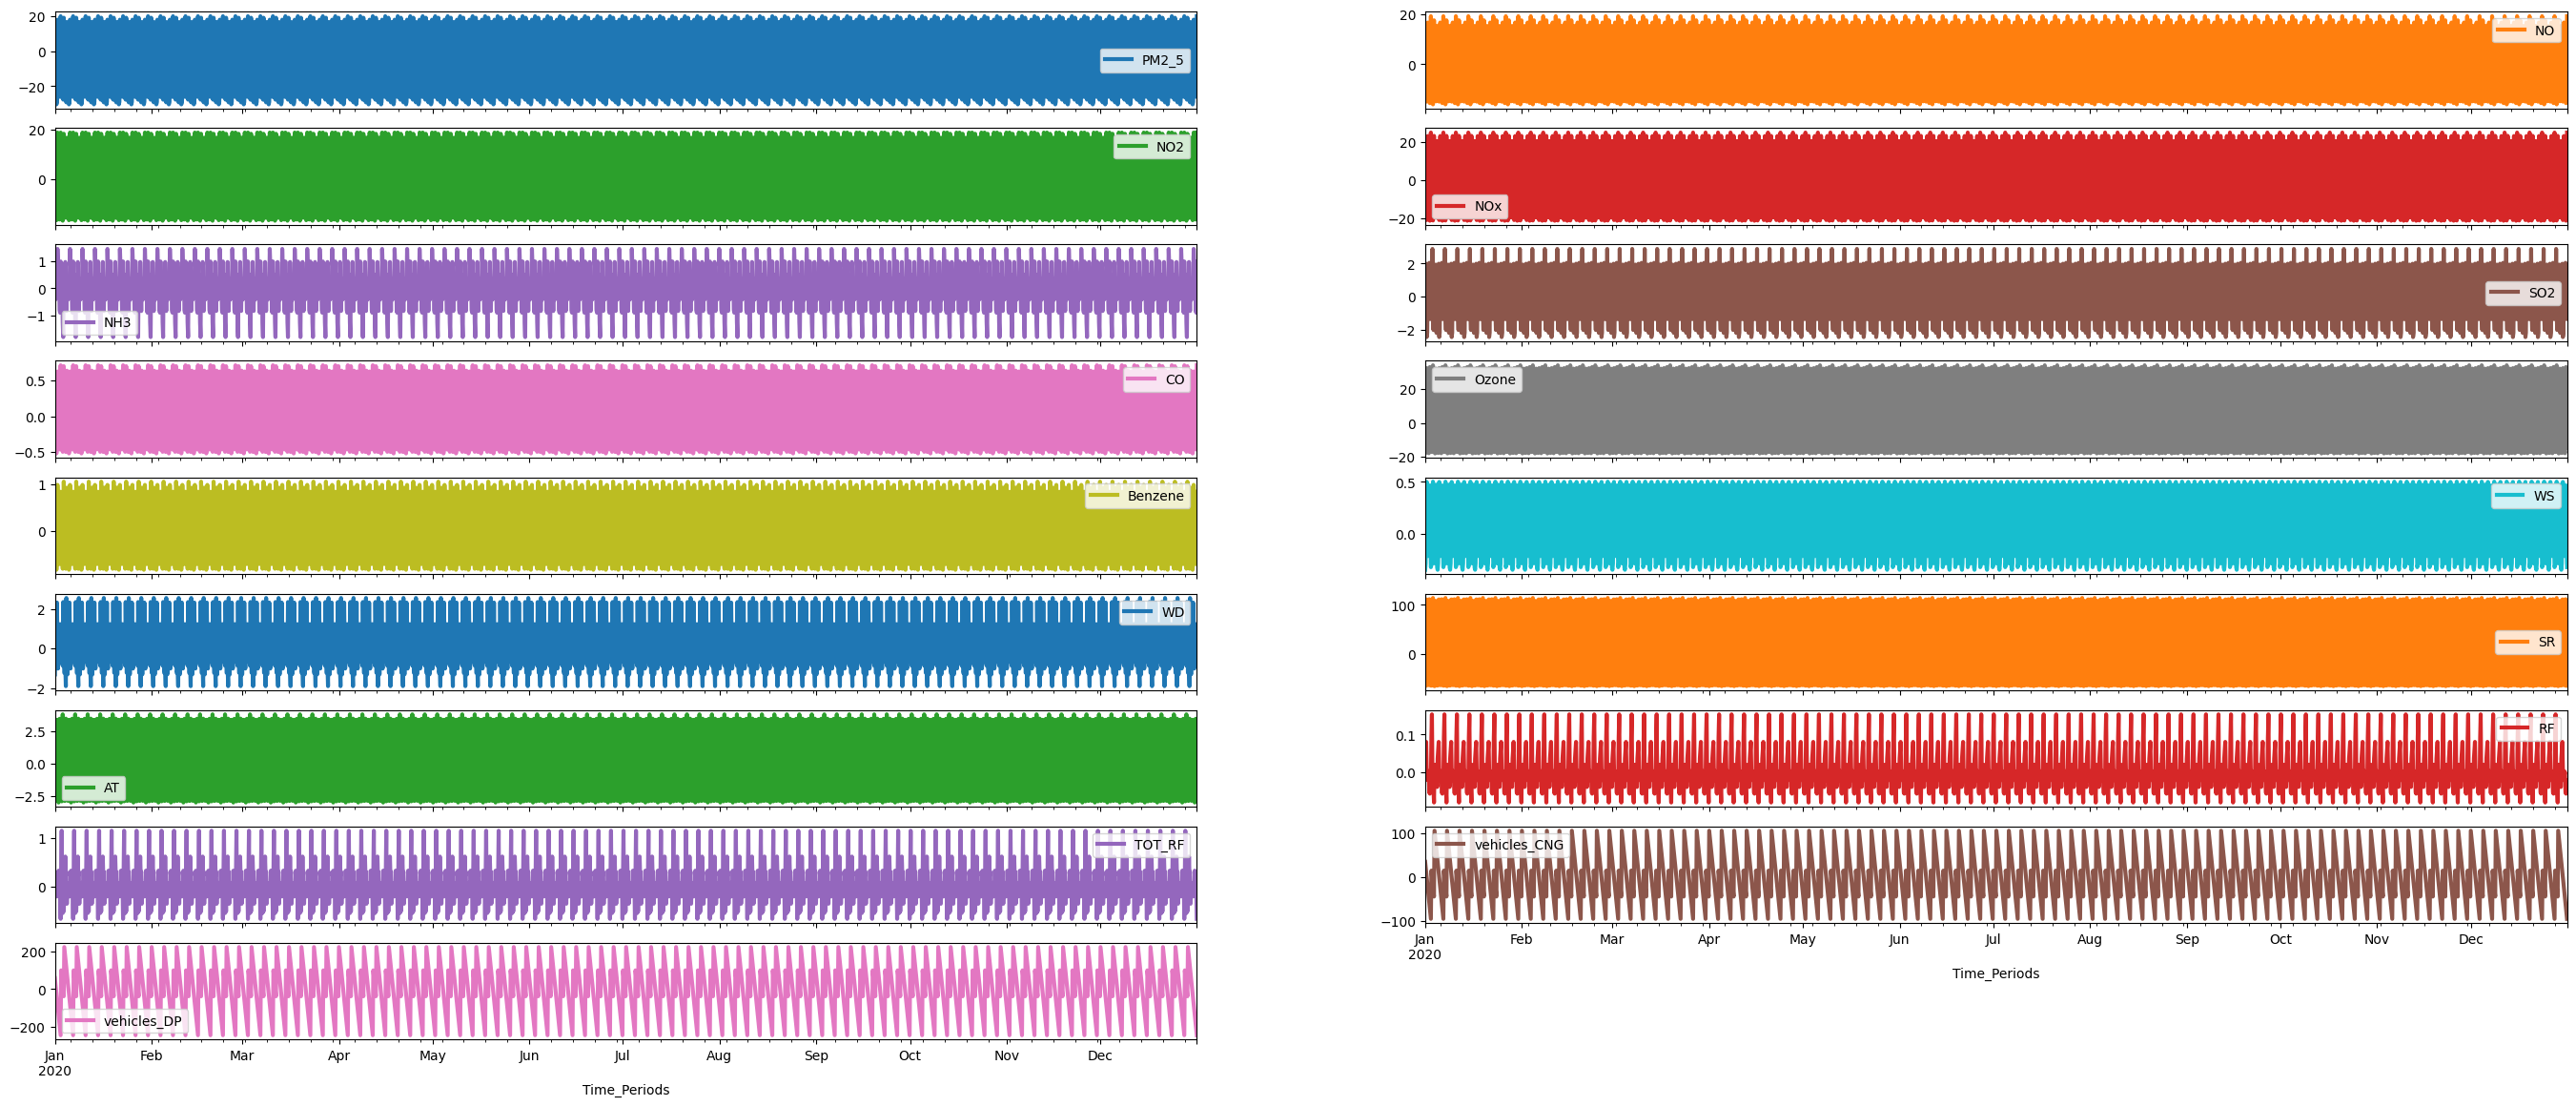

In [ ]:
# Init empty dict to store decompose results
seasonality_dict = {}

for ts in df_GHZ.columns:
    decompositions = sm.tsa.seasonal_decompose(df_GHZ[ts].dropna())
    # Store the results back
    seasonality_dict[ts] = decompositions.seasonal

# Plot
rcParams["figure.figsize"] = 34, 14
pd.DataFrame(seasonality_dict)["2020":"2020"].plot(
    subplots=True, layout=(9, 2), linewidth=3
);

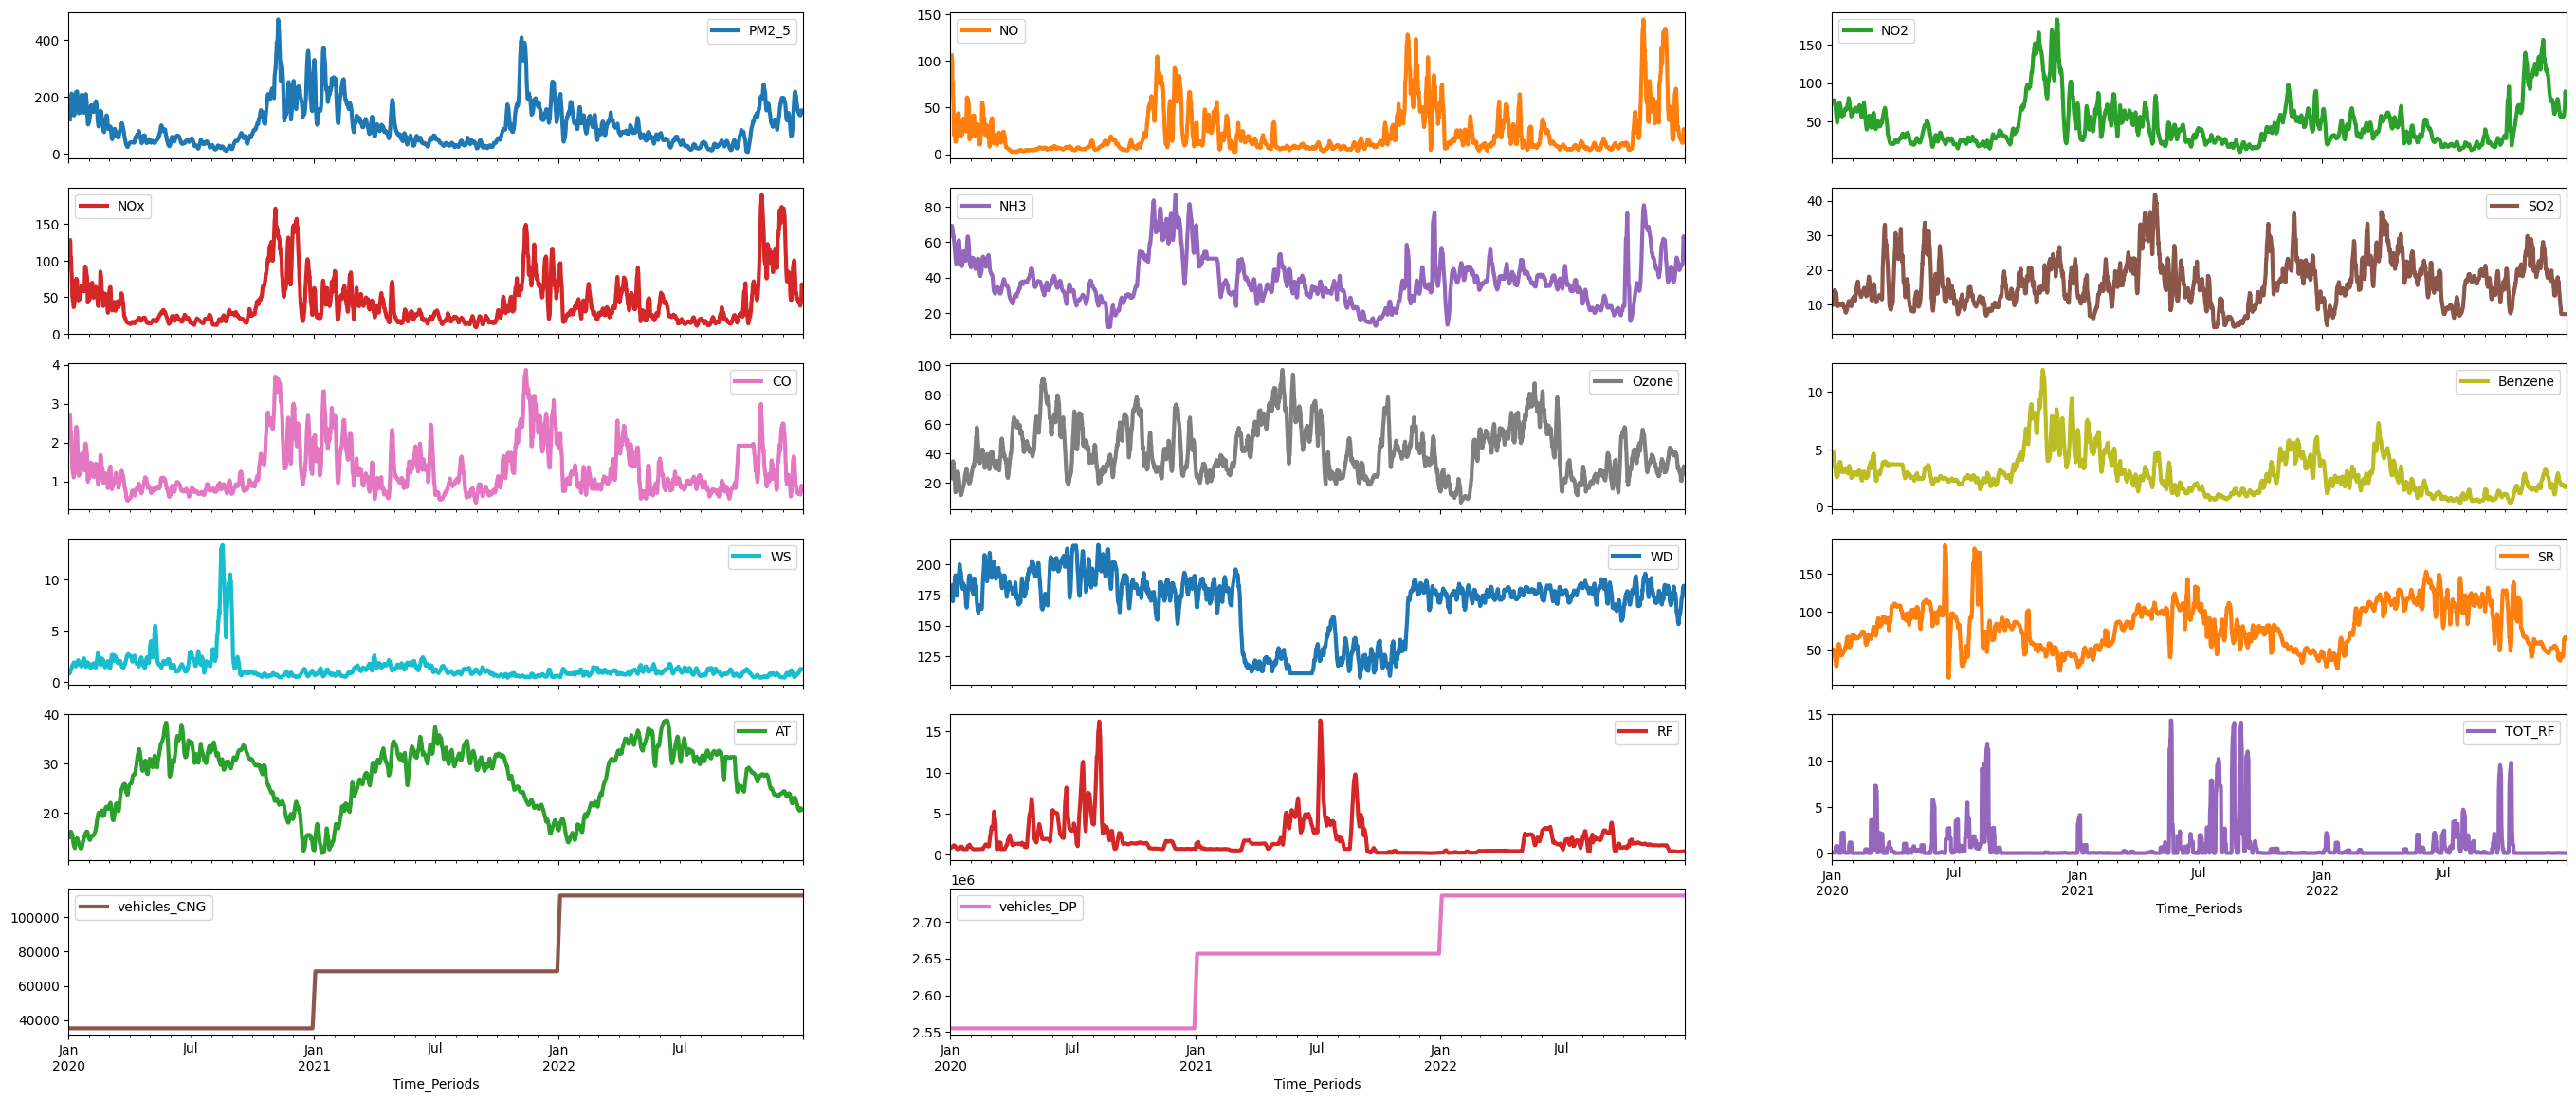

In [ ]:
trend_dict = {}

for ts in df_GHZ.columns:
    decomposition = sm.tsa.seasonal_decompose(df_GHZ[ts].dropna())
    # Store back the results
    trend_dict[ts] = decomposition.trend

pd.DataFrame(trend_dict).plot(subplots=True, layout=(6, 3), linewidth=3);

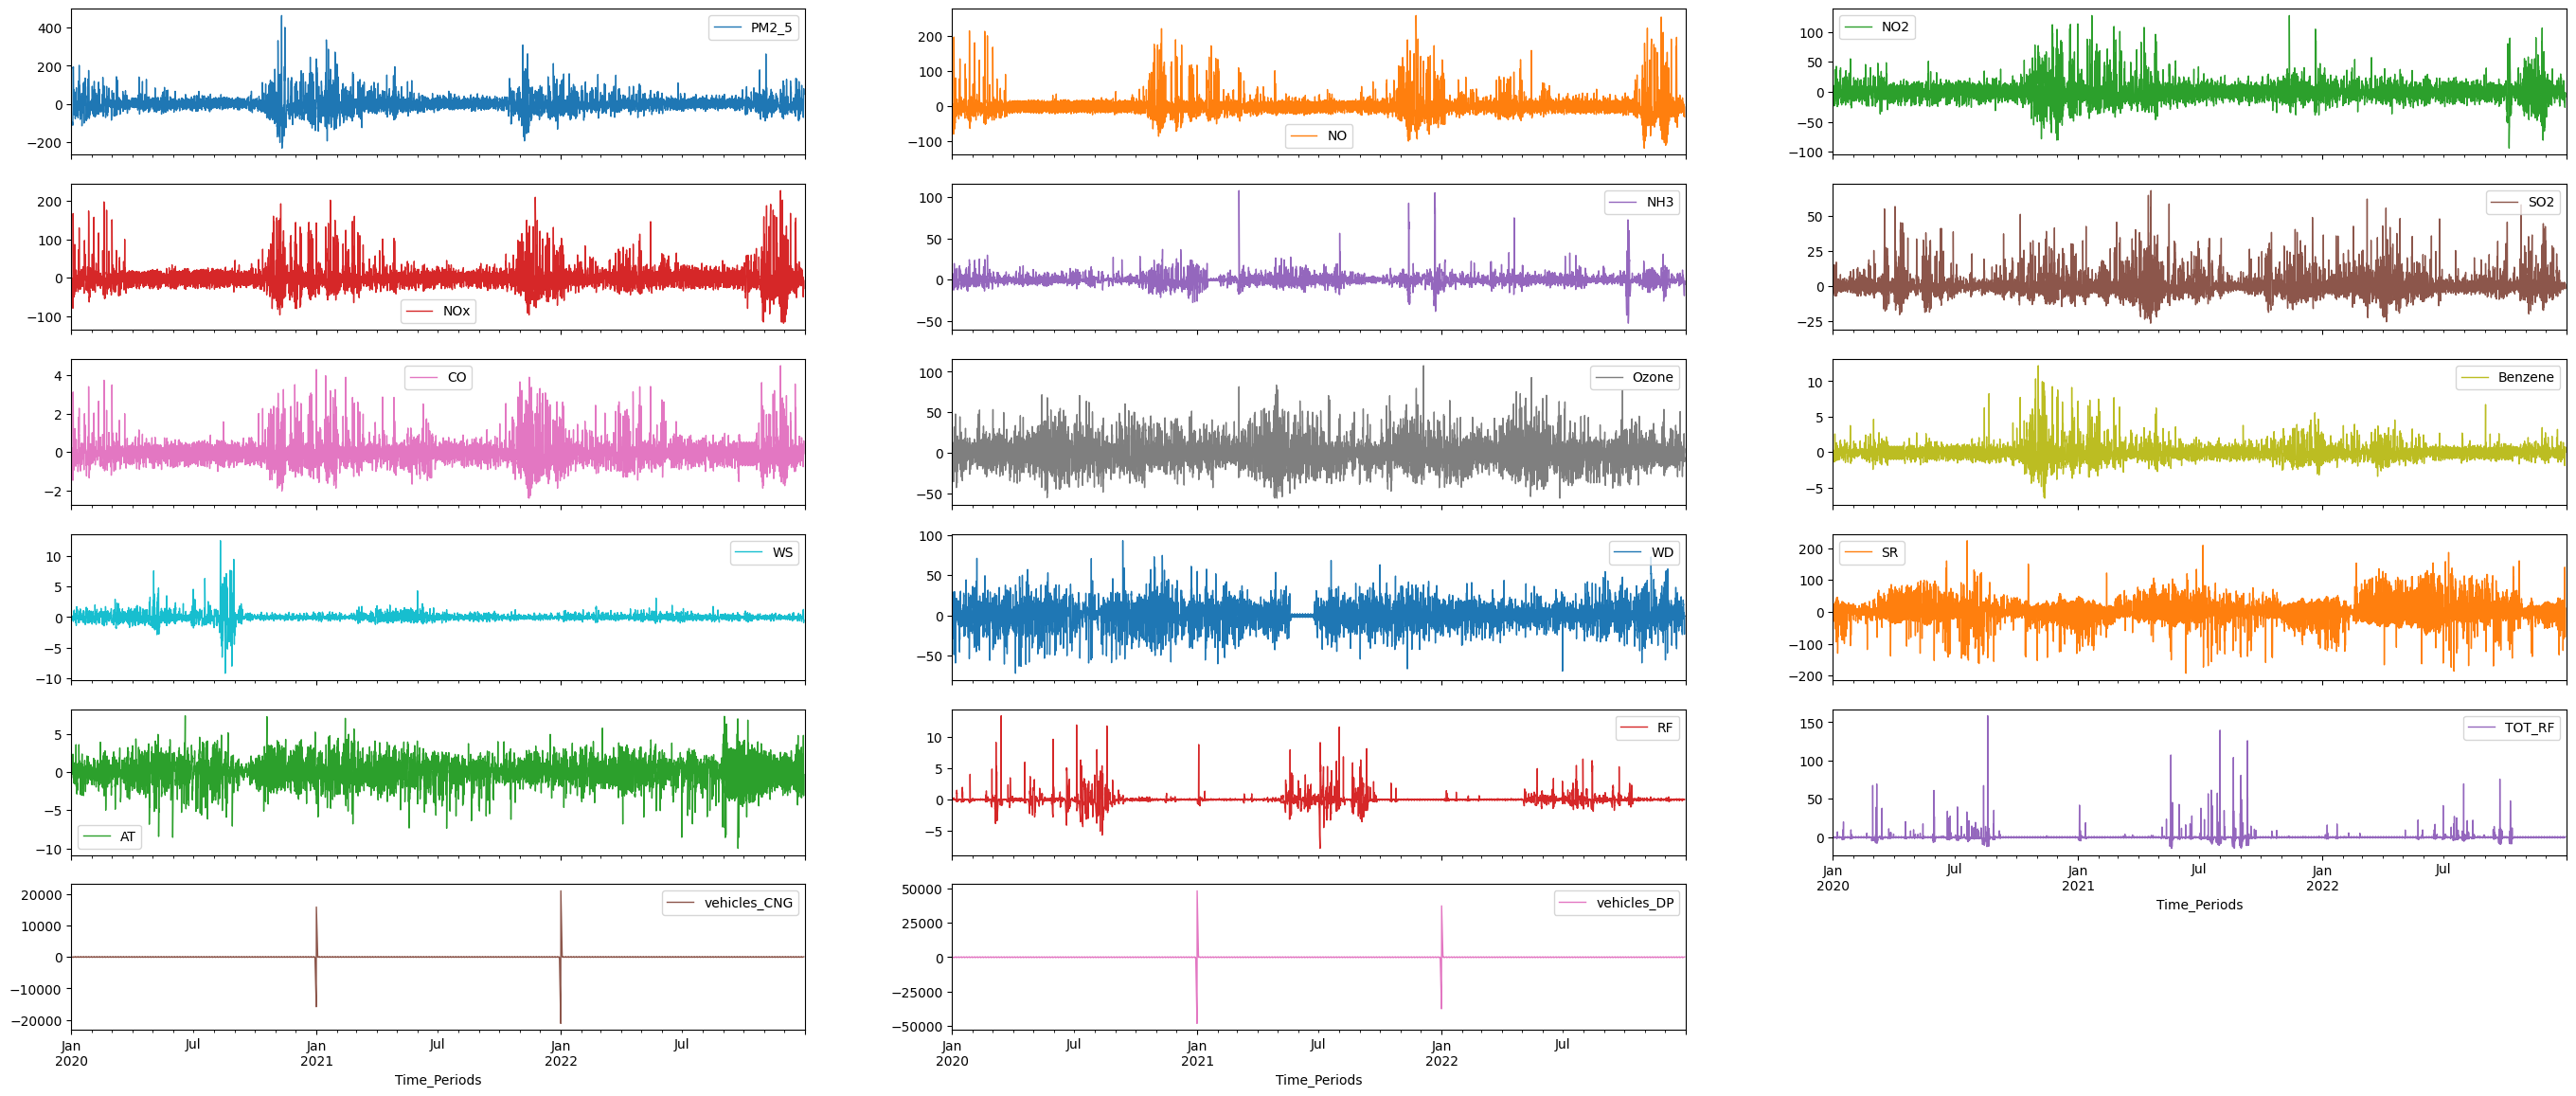

In [ ]:
resid_dict = {}

for ts in df_GHZ.columns:
    decomposition = sm.tsa.seasonal_decompose(df_GHZ[ts].dropna())
    resid_dict[ts] = decomposition.resid

pd.DataFrame(resid_dict).plot(subplots=True, layout=(6, 3), linewidth=1);

In [ ]:
df_GHZ.columns

Index(['PM2_5', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene',
       'WS', 'WD', 'SR', 'AT', 'RF', 'TOT_RF', 'vehicles_CNG', 'vehicles_DP'],
      dtype='object')

In [ ]:
df_GHZ = df_GHZ.drop(['vehicles_CNG', 'vehicles_DP'],axis=1)

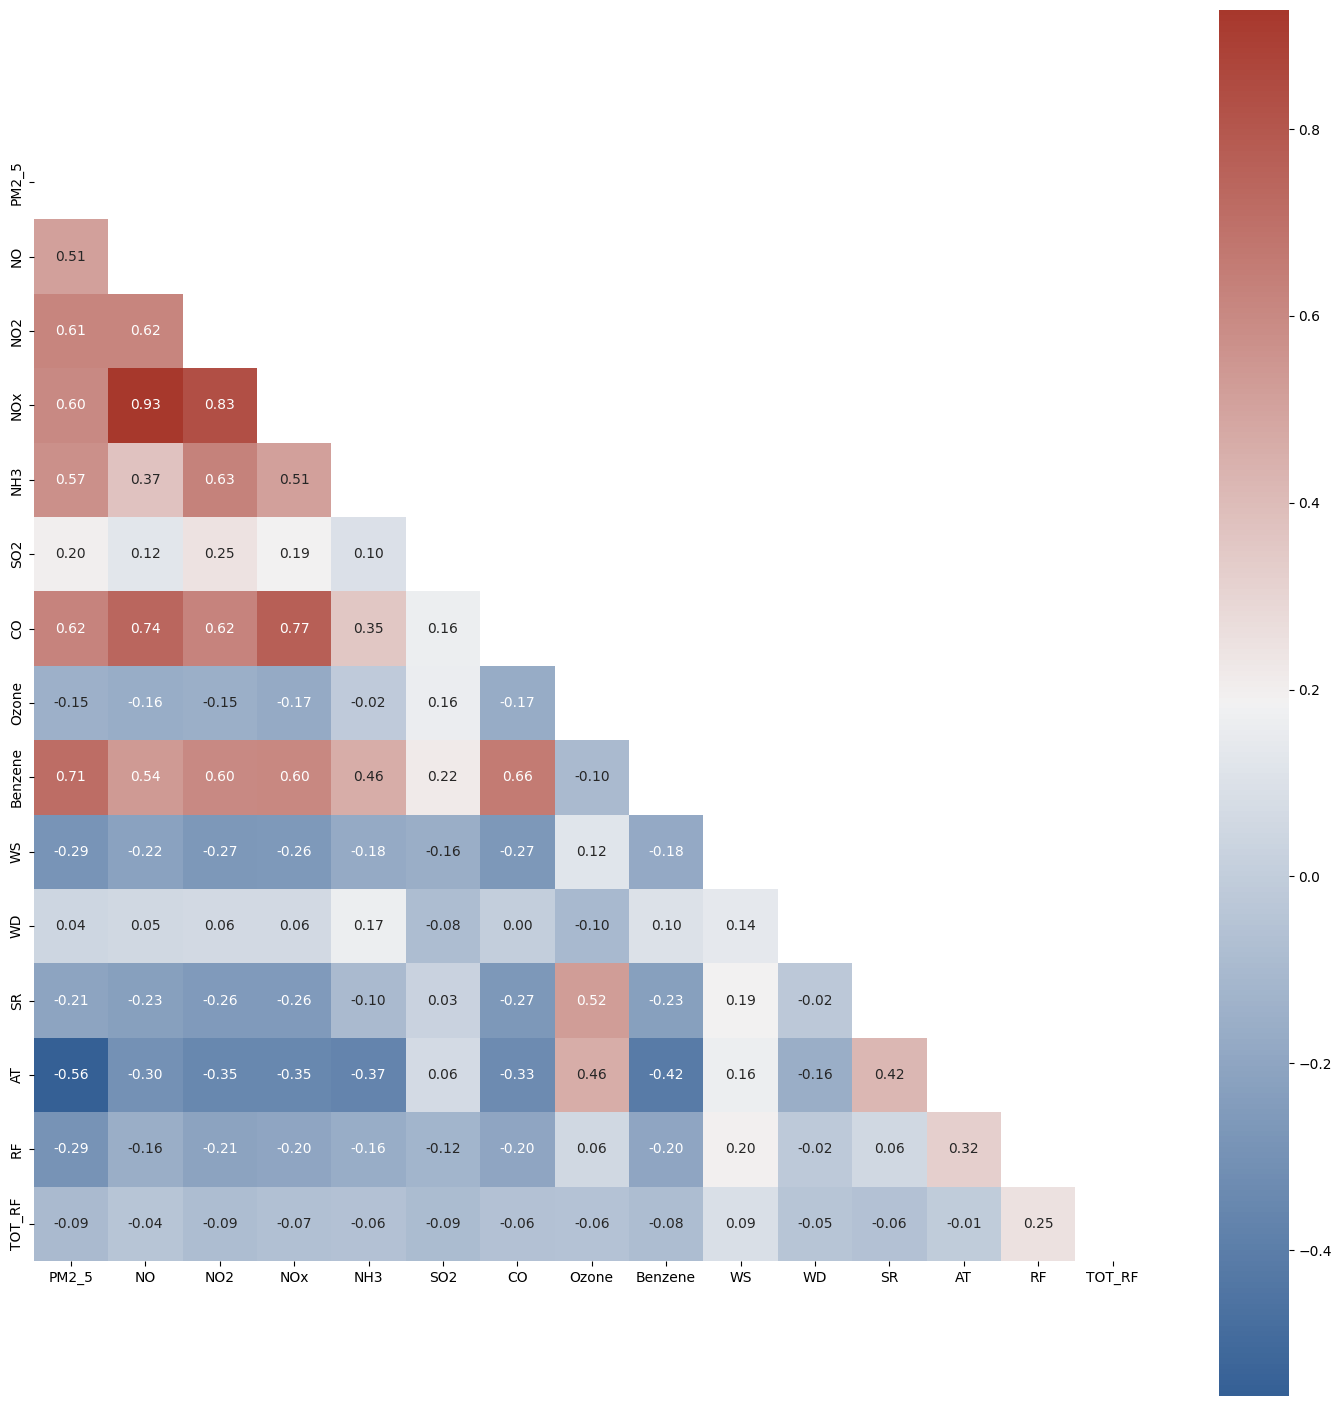

In [ ]:
# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = df_GHZ.corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show();

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


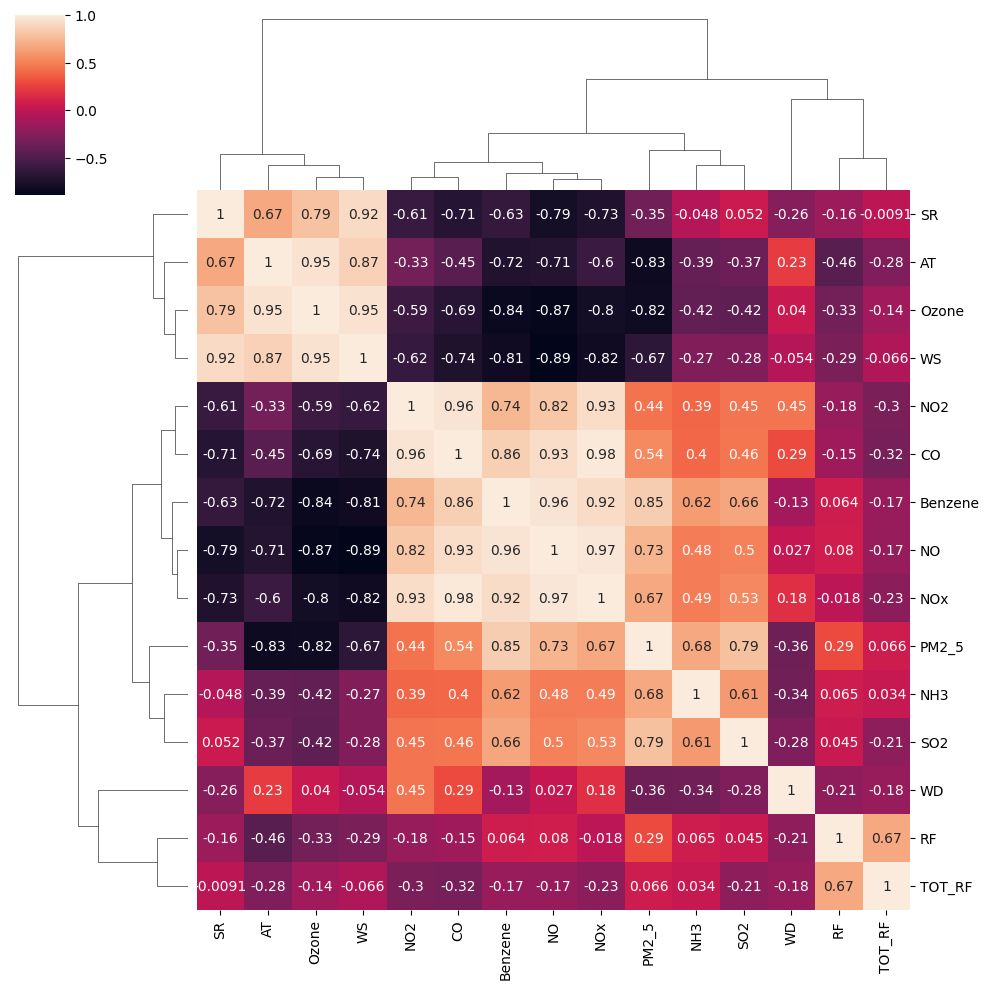

In [ ]:
seasonality_dict = {
    ts: sm.tsa.seasonal_decompose(df_GHZ[ts].dropna()).seasonal for ts in df_GHZ.columns
}

# Compute corr matrix
seasonality_corr = pd.DataFrame(seasonality_dict).corr()

sns.clustermap(seasonality_corr, annot=True, square=True)
plt.show();

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


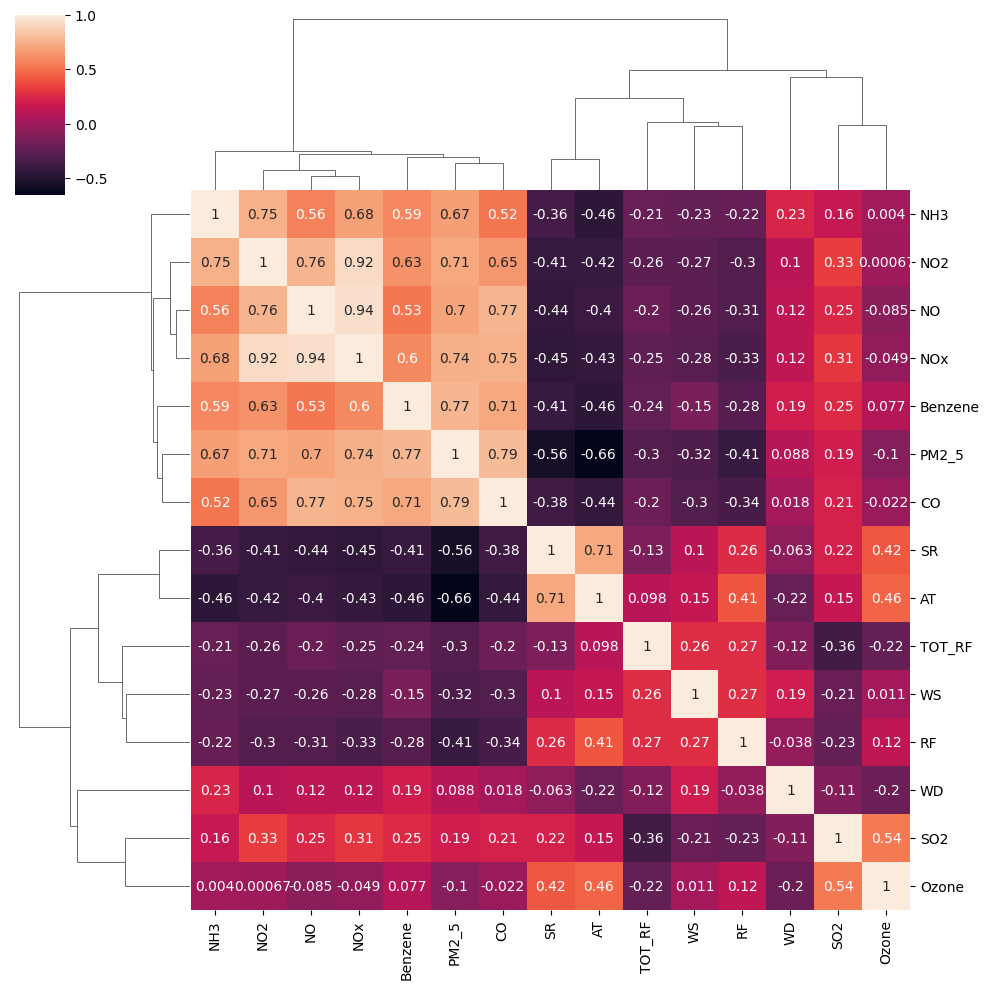

In [ ]:
trend_dict = {
    ts: sm.tsa.seasonal_decompose(df_GHZ[ts].dropna()).trend for ts in df_GHZ.columns
}

# Compute corr matrix
trend_dict = pd.DataFrame(trend_dict).corr()

sns.clustermap(trend_dict, annot=True, square=True)
plt.show();

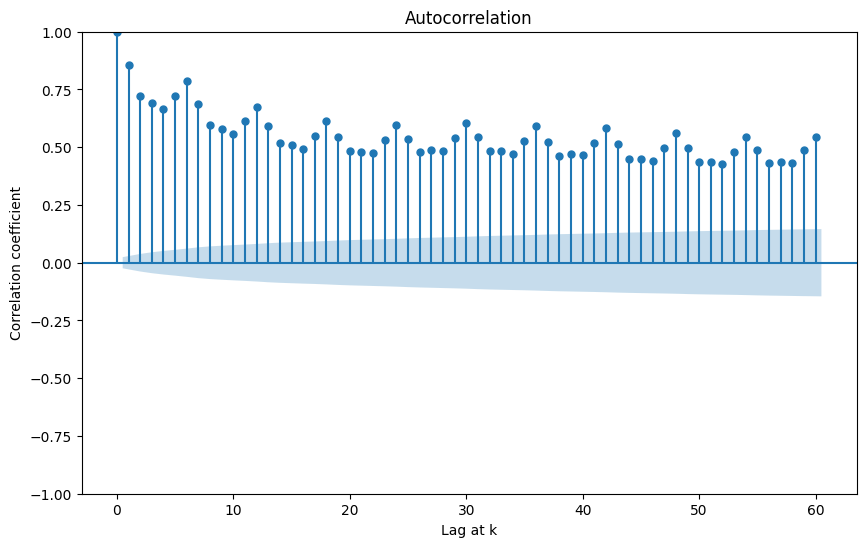

In [ ]:
from statsmodels.graphics import tsaplots

rcParams["figure.figsize"] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(df_GHZ["PM2_5"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

#Visualization

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


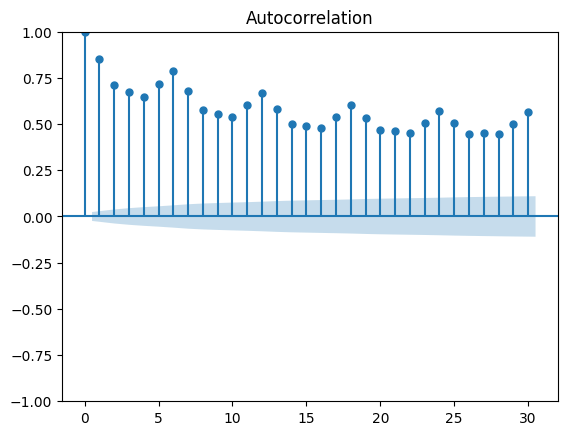

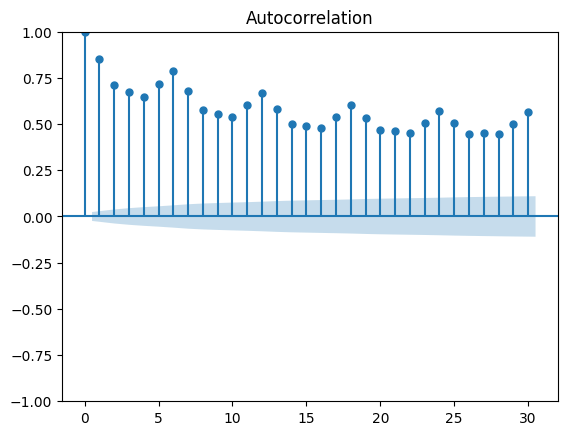

In [ ]:
#correlation 
plot_acf(df_GHZ.PM2_5,lags=30)

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


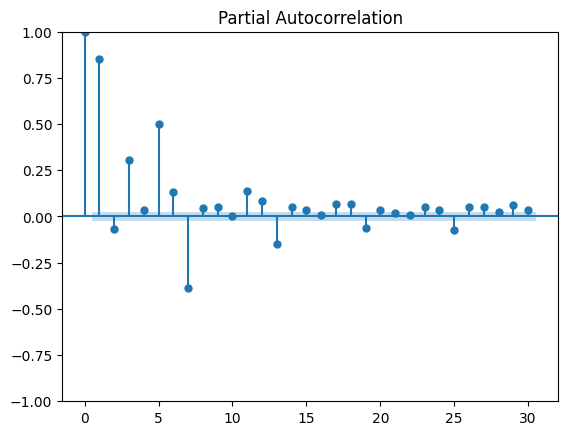

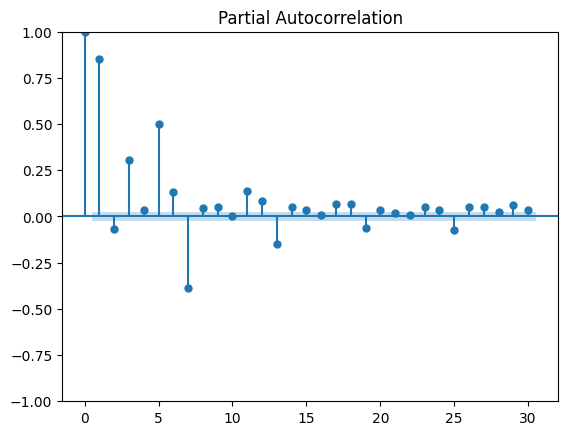

In [ ]:
#partial correlation
plot_pacf(df_GHZ.PM2_5,lags=30)

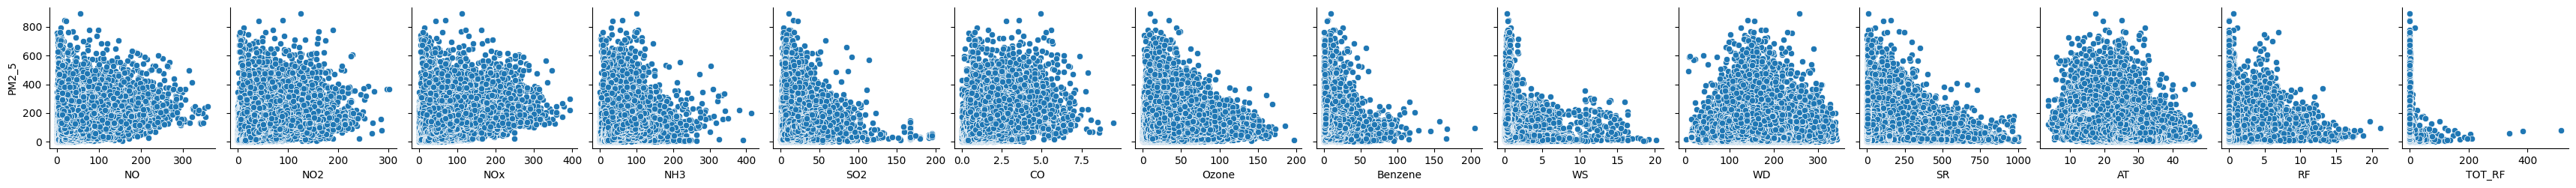

In [ ]:
sns.pairplot(data=df_1,y_vars = ['PM2_5'],x_vars = [ 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene',
       'WS', 'WD', 'SR', 'AT', 'RF', 'TOT_RF'])

<Axes: xlabel='City', ylabel='PM2_5'>

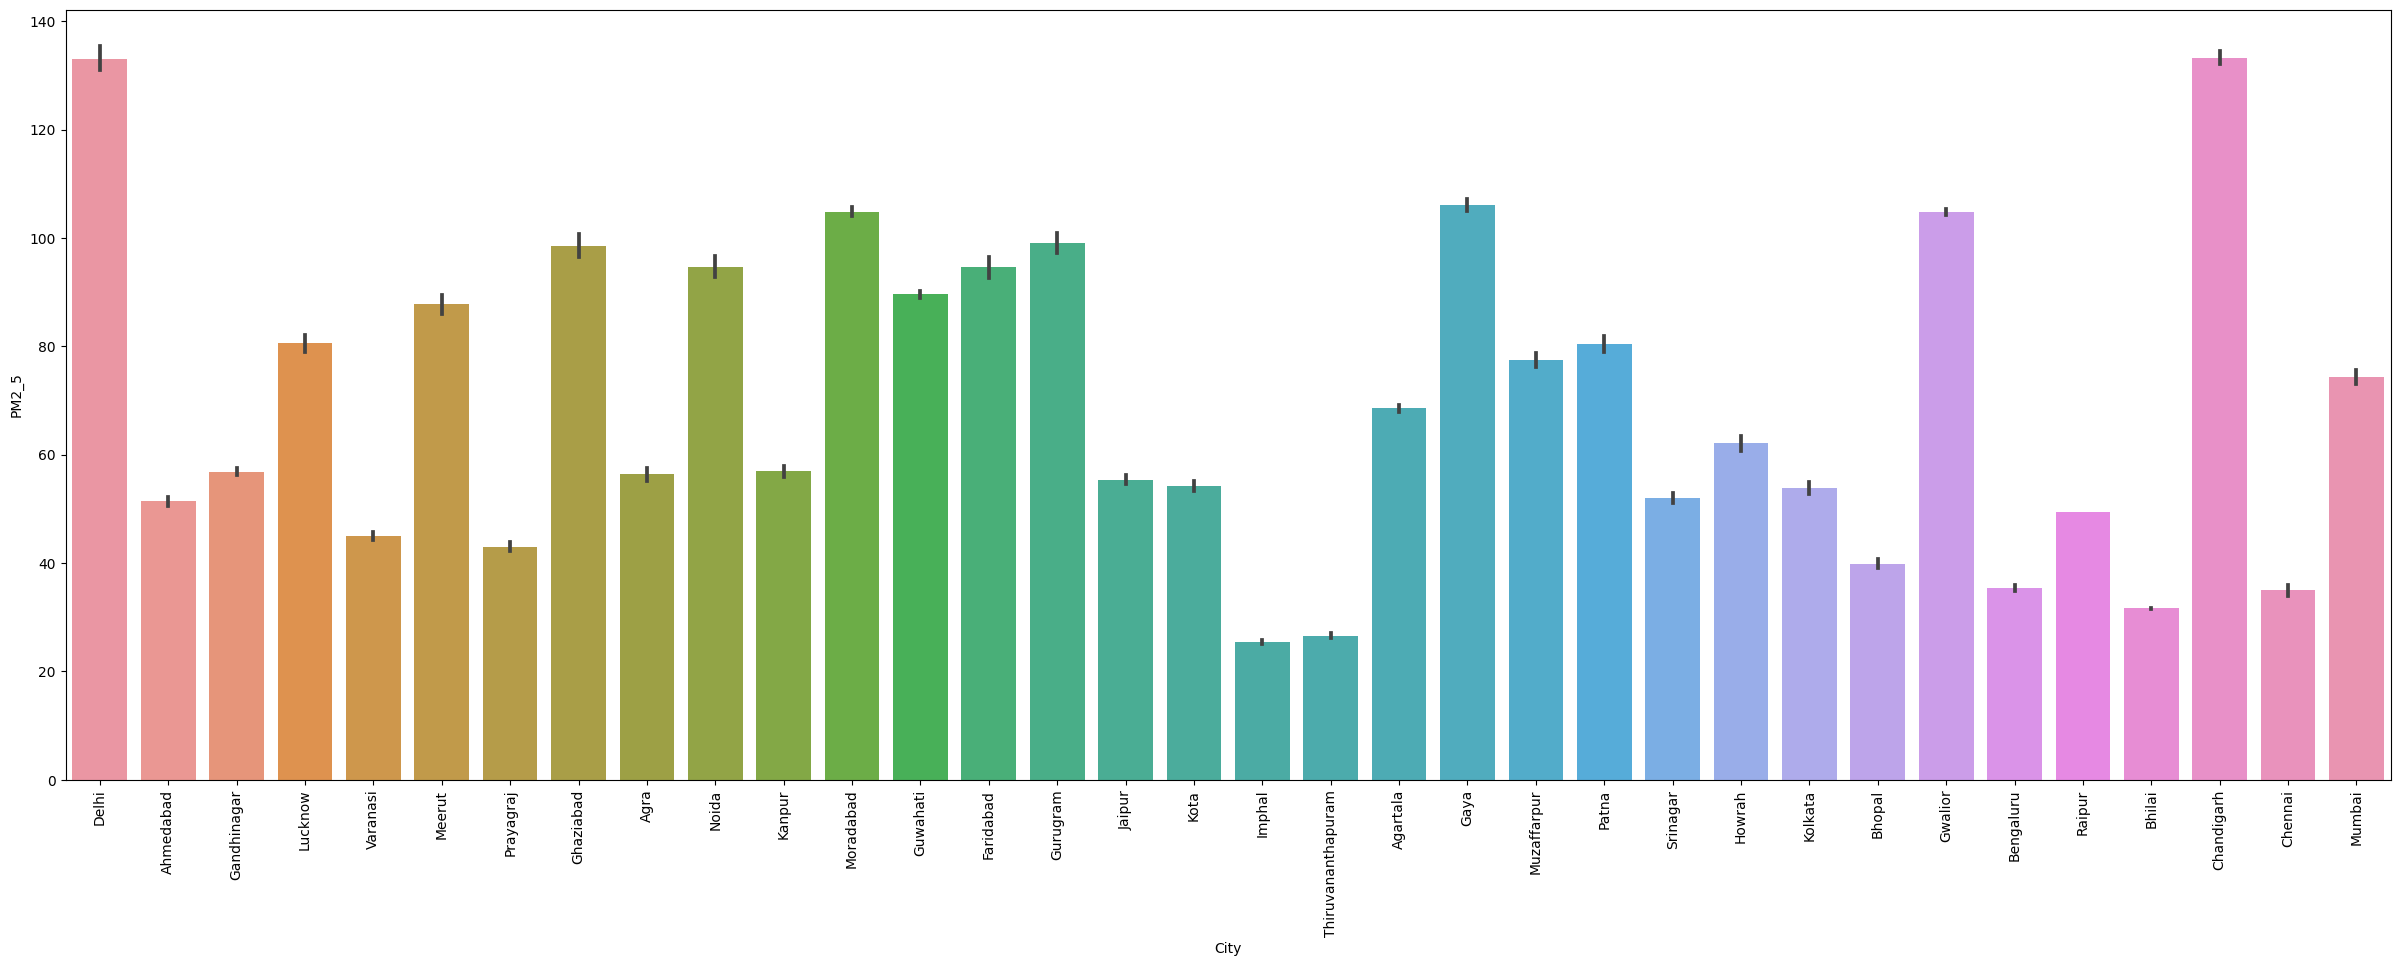

In [ ]:
plt.figure(figsize=(30,10))
plt.xticks(rotation=90)
sns.barplot(x='City',y='PM2_5',data=df_1)

<Axes: xlabel='City'>

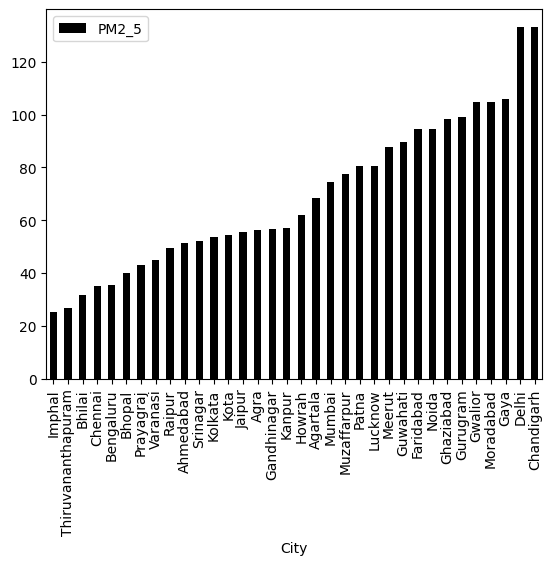

In [ ]:
plt.figure(figsize=(40,10))
df_1[['PM2_5','City']].groupby(['City']).mean().sort_values(by='PM2_5').plot.bar(color='Black')

<Axes: ylabel='Frequency'>

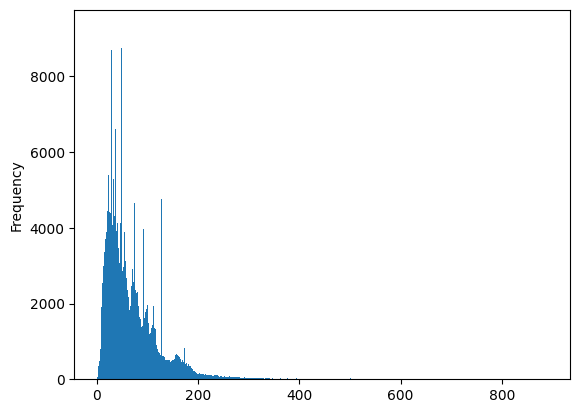

In [ ]:
df_1['PM2_5'].plot(kind='hist', bins=500)


<Axes: title={'center': 'High Values'}, xlabel='Time_Periods'>

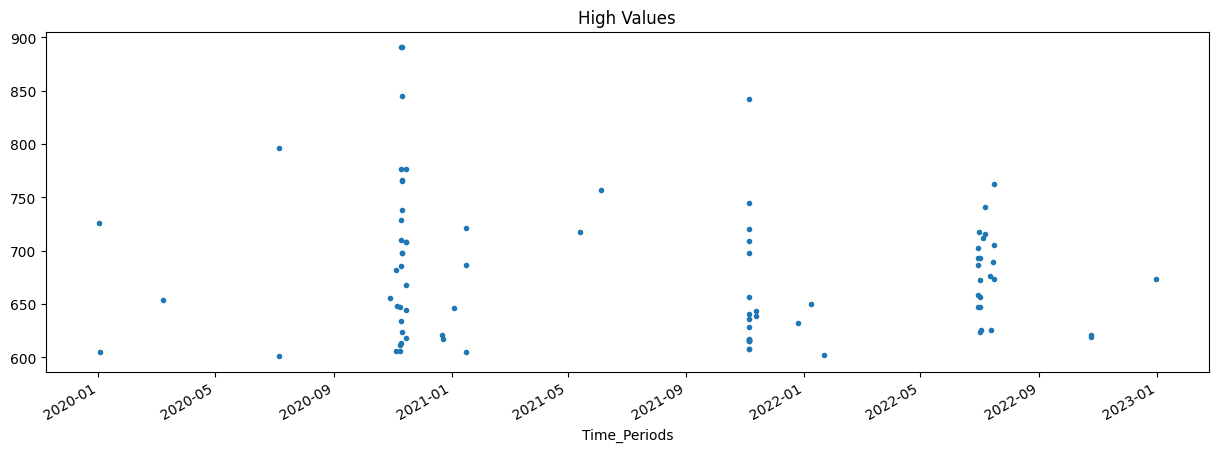

In [ ]:
df_1.query('PM2_5 > 600')['PM2_5'] \
    .plot(style='.',
          figsize=(15, 5),
          title='High Values')

**From the above graph we can see higher PM2.5 values in the year end.**

In [ ]:
print('Cities with highest PM2_5 level recorded:')
set(df_1.query('PM2_5 > 800')['City'])

Cities with highest PM2_5 level recorded:


{'Ghaziabad', 'Noida'}

**Visualization using one city-Ghaziabad**

In [ ]:
df_GHZ = df_1[df_1['City']=='Ghaziabad']

In [ ]:
#For easier representation lets drop some features
required_feat = ['PM2_5', 'NO', 'NO2', 'NOx', 'NH3', 'SO2', 'CO', 'Ozone', 'Benzene',
       'WS', 'WD', 'SR', 'AT', 'RF', 'TOT_RF']
df_GHZ = df_GHZ[required_feat]

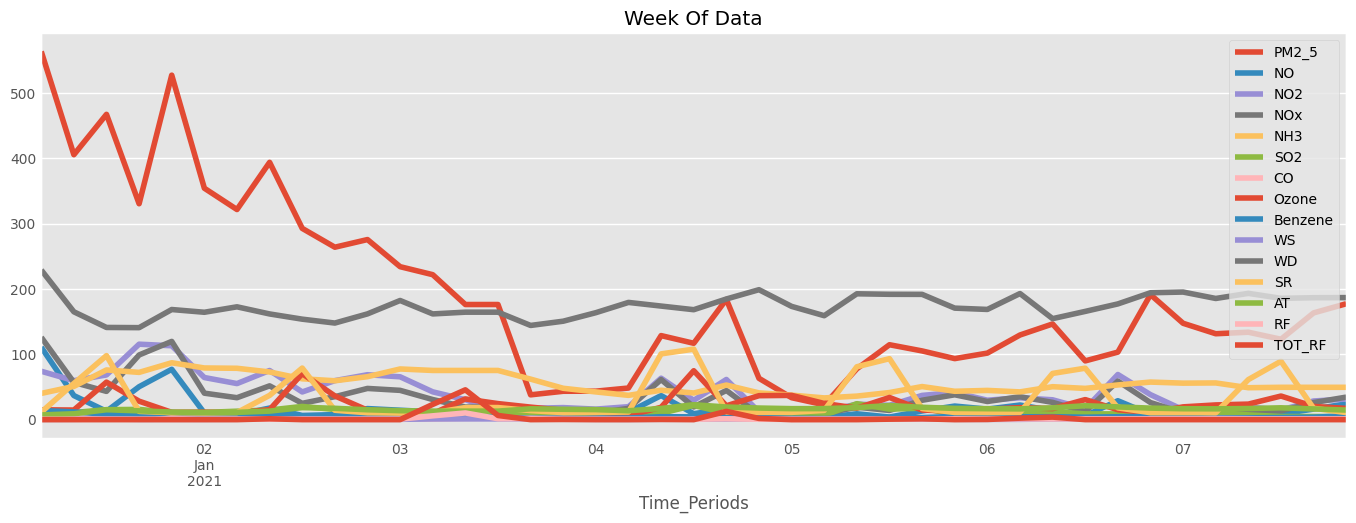

In [ ]:
df_GHZ.loc[(df_GHZ.index > '01-01-2021') & (df_GHZ.index < '01-08-2021')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [ ]:
color_pal = sns.color_palette()
def plot_element(temp):
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.style.use('ggplot')
    temp.plot(ax=ax ,style='.',
            color=color_pal[0],
            title=i+' LEVELS ')
    df_GHZ['PM2_5'].plot.line(ax=ax ,
        color=color_pal[1],linewidth = 0.5)
    plt.show()

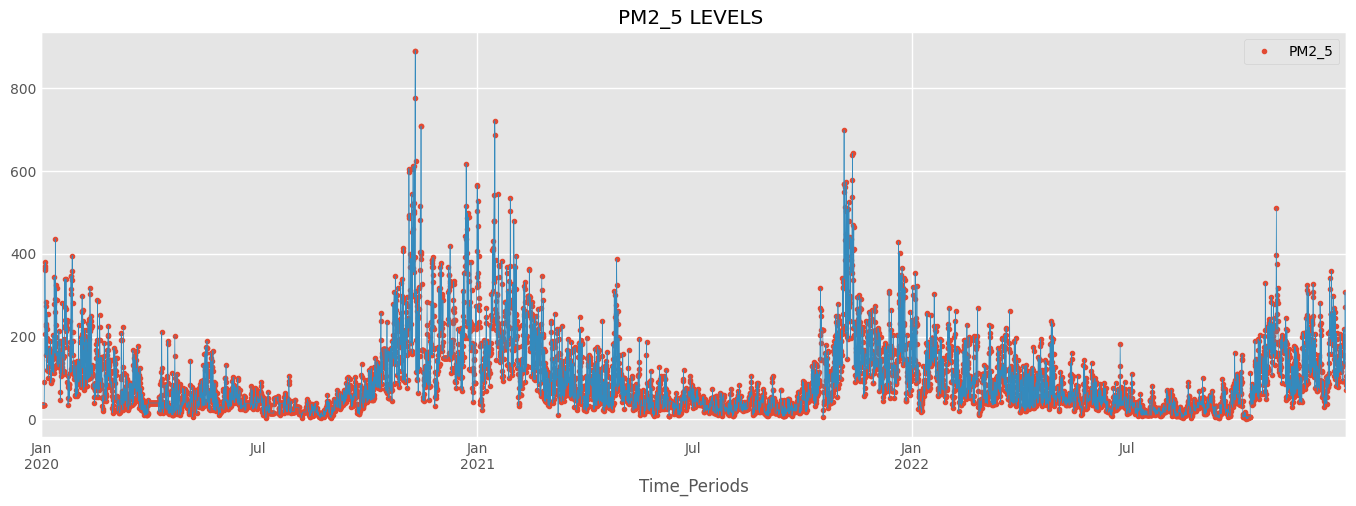

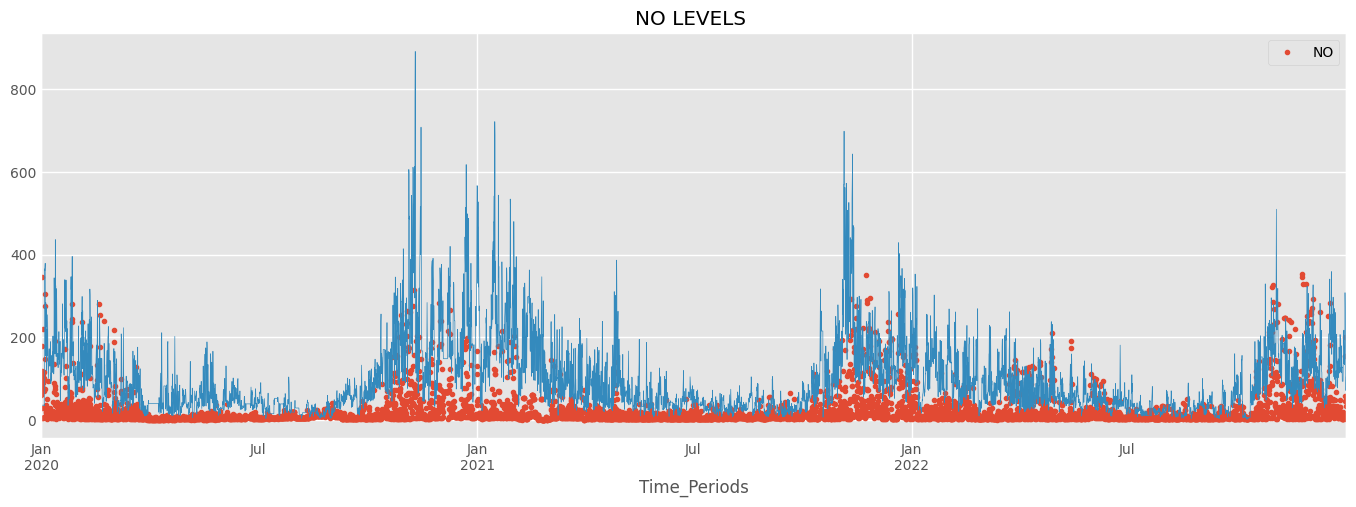

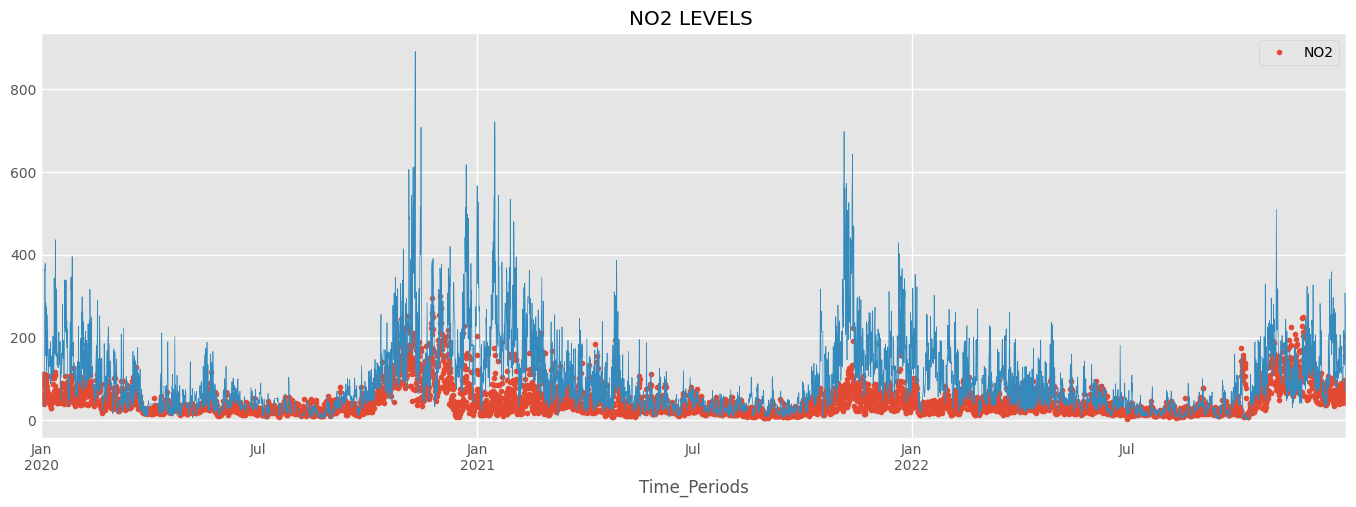

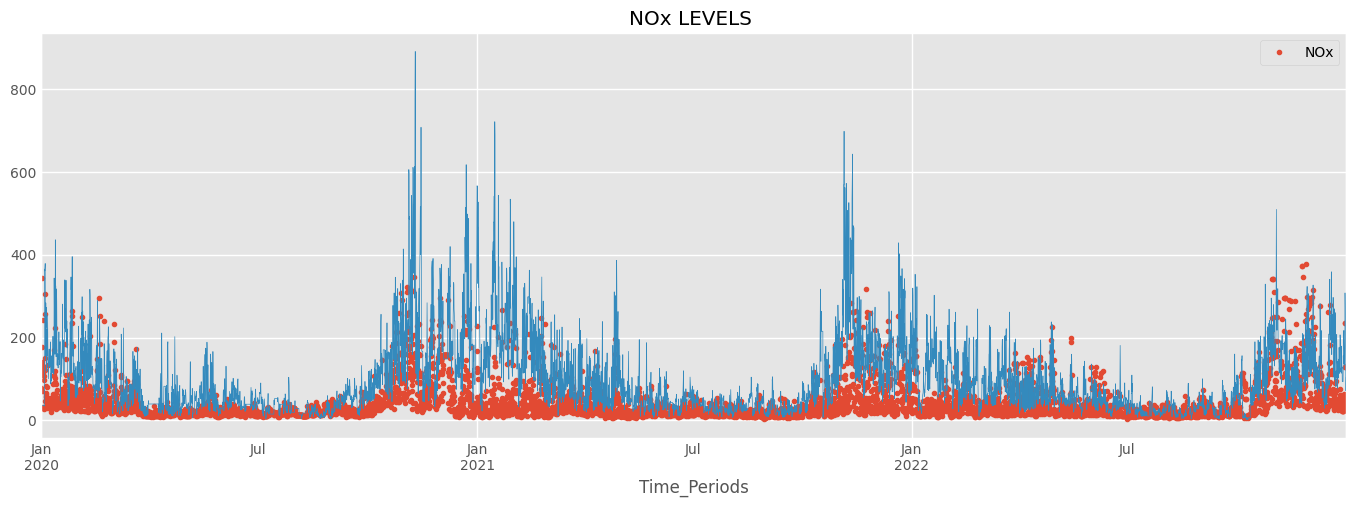

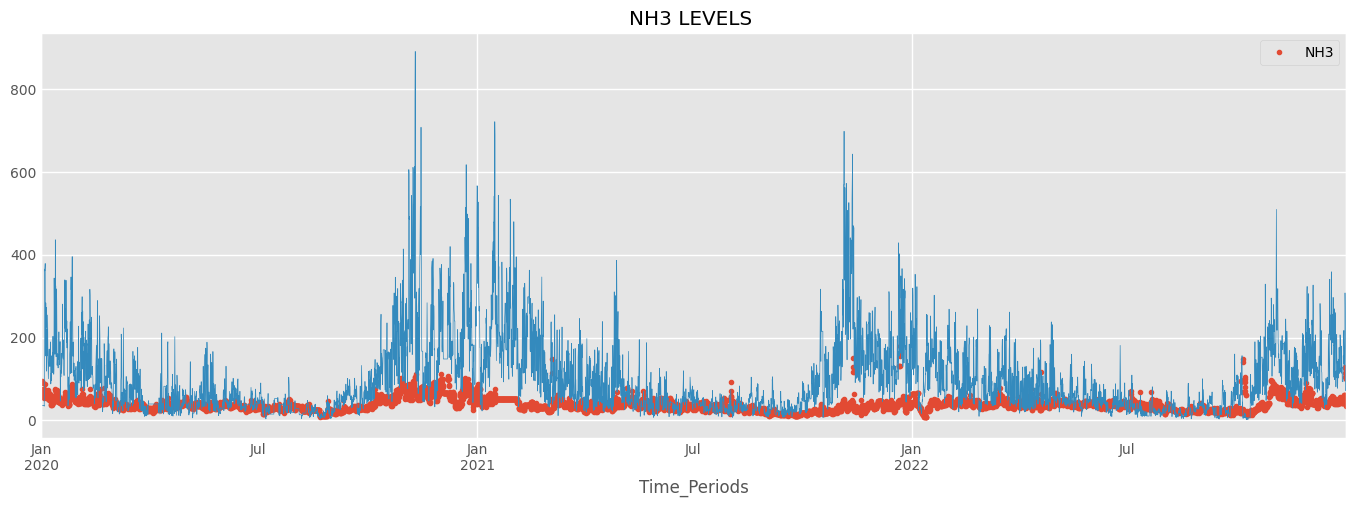

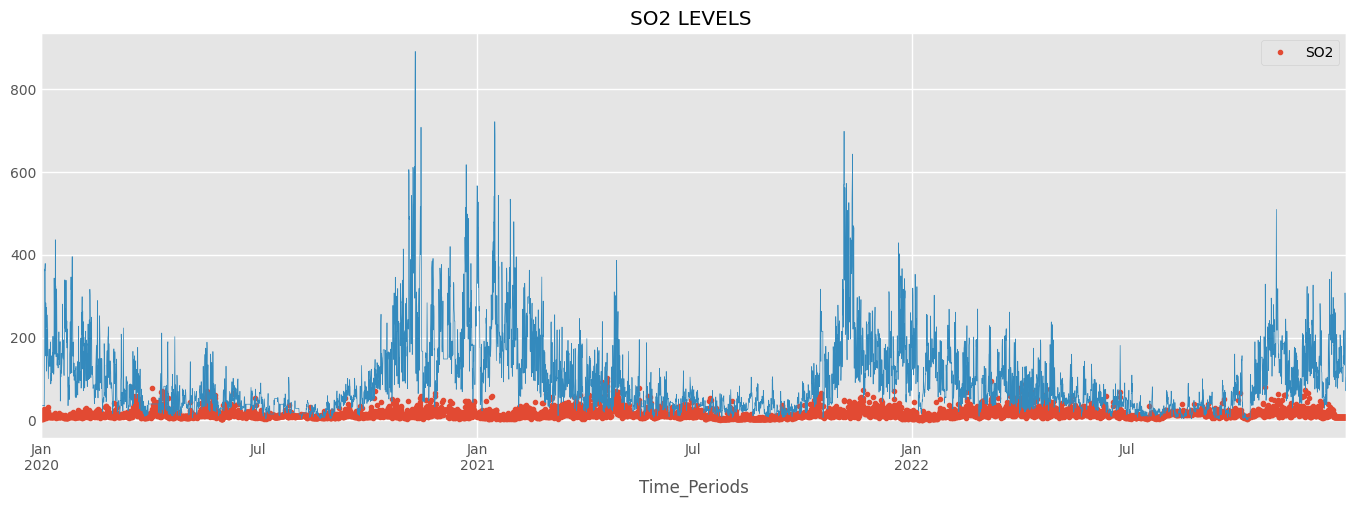

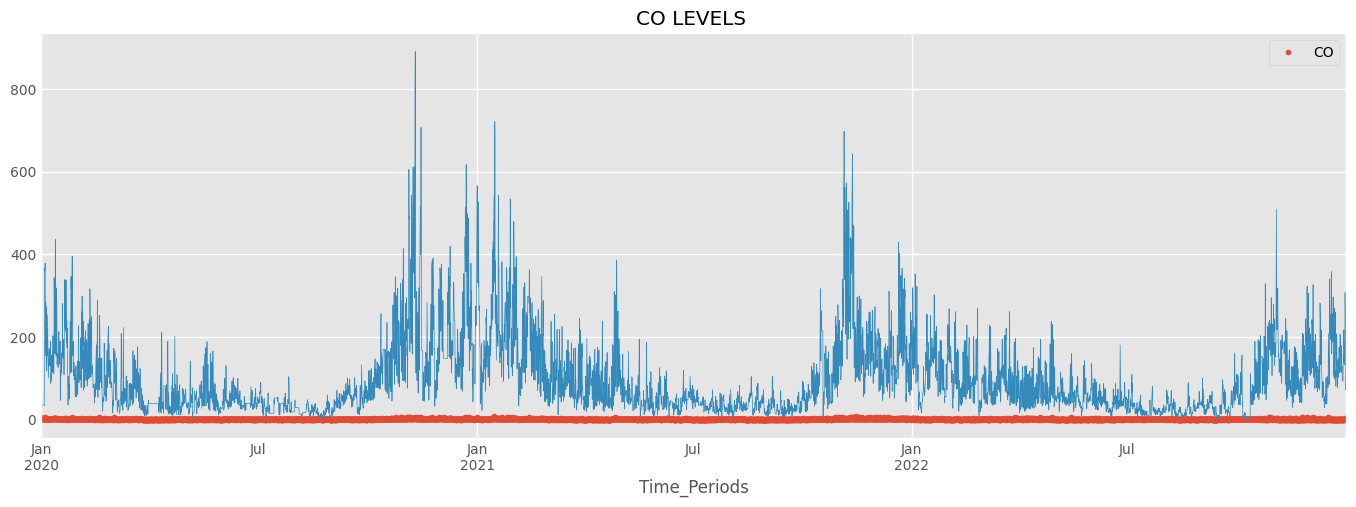

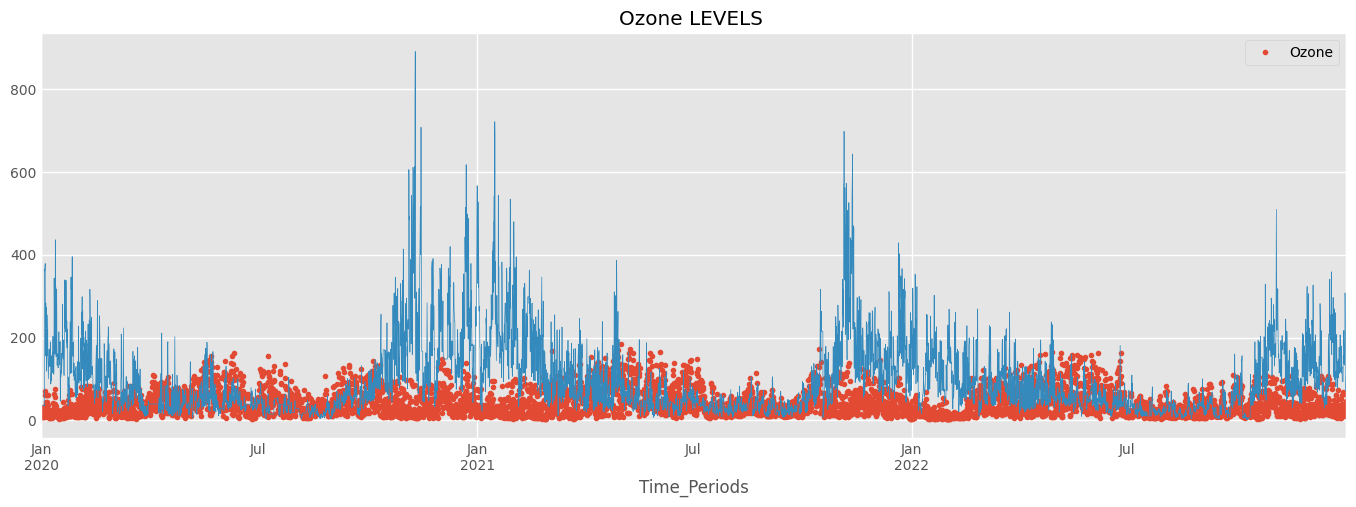

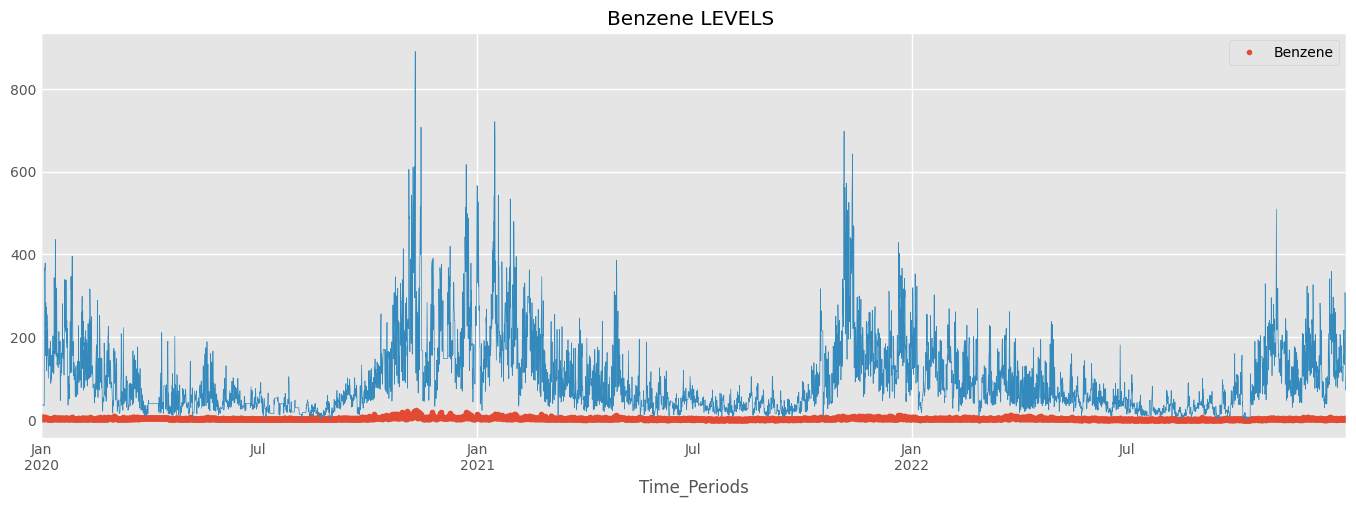

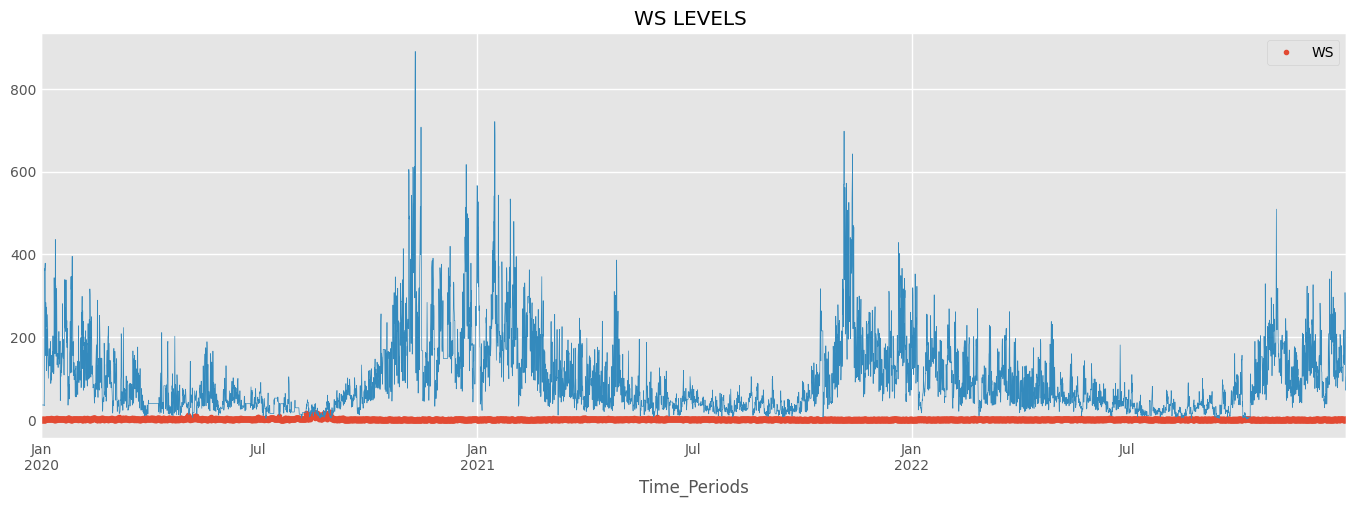

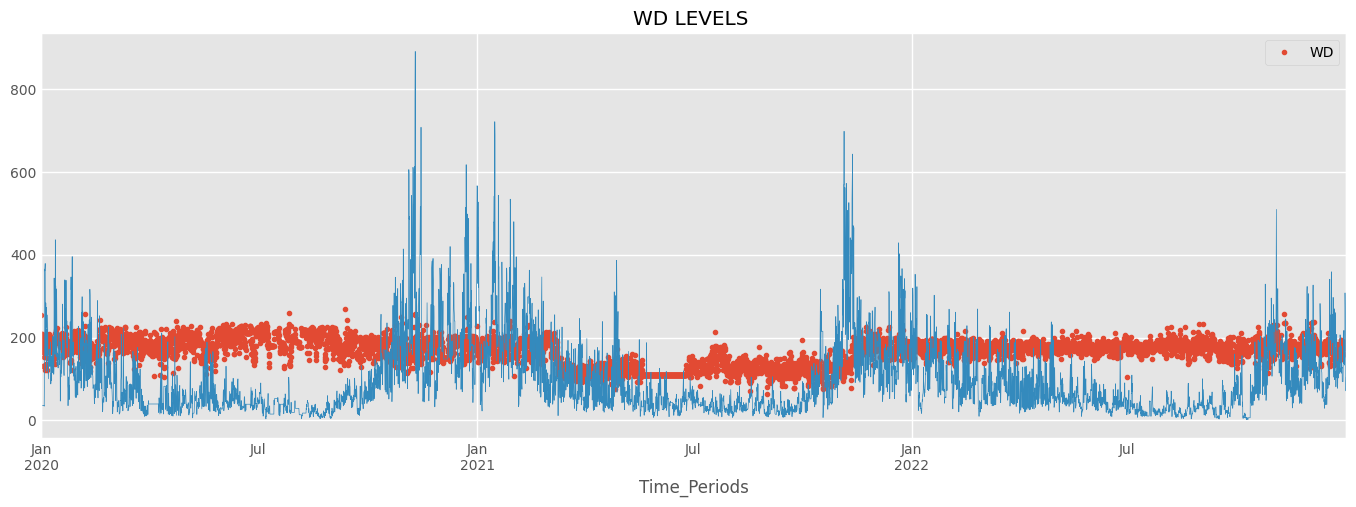

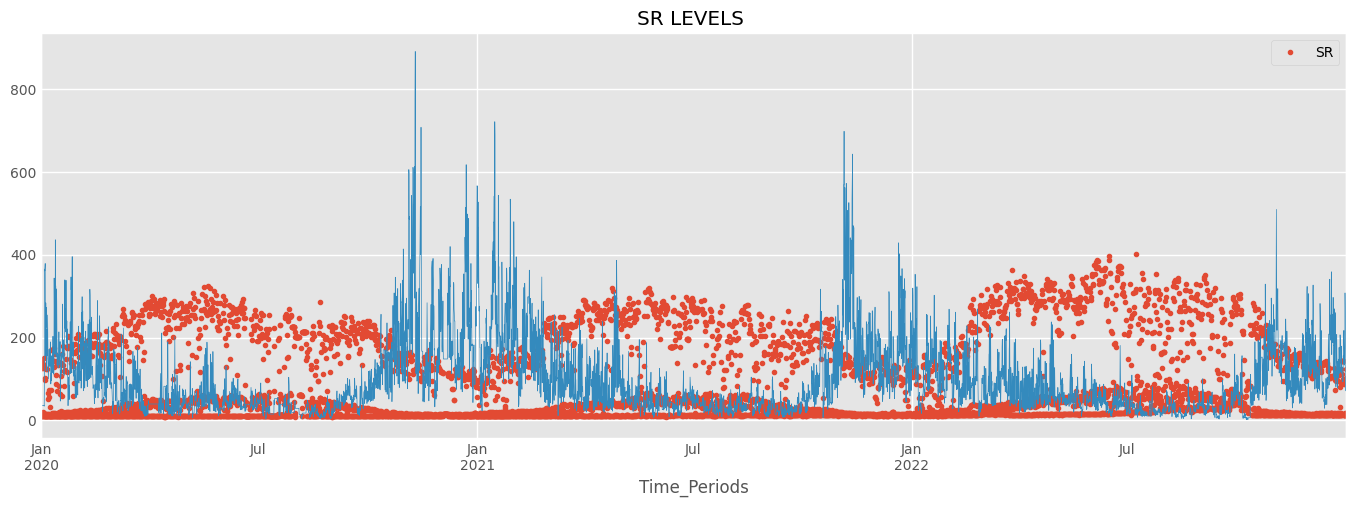

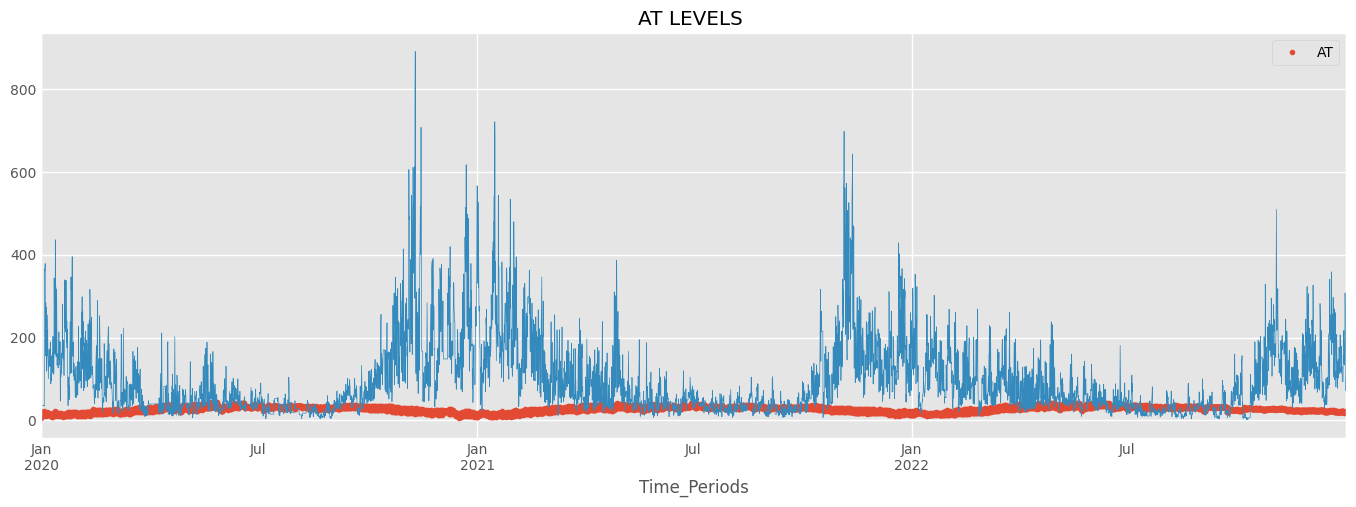

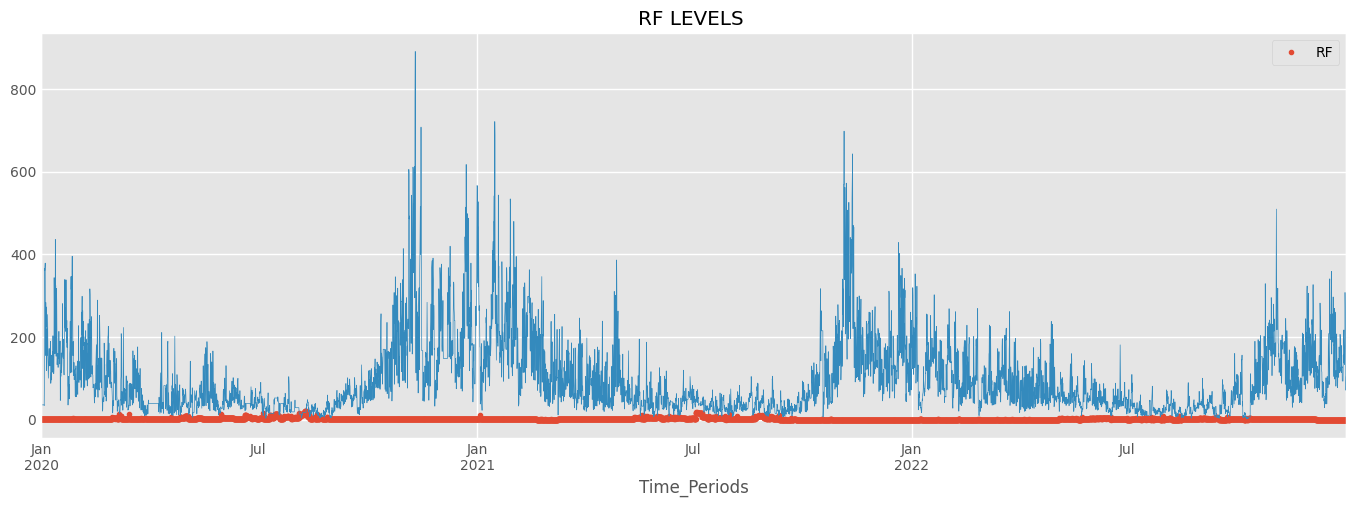

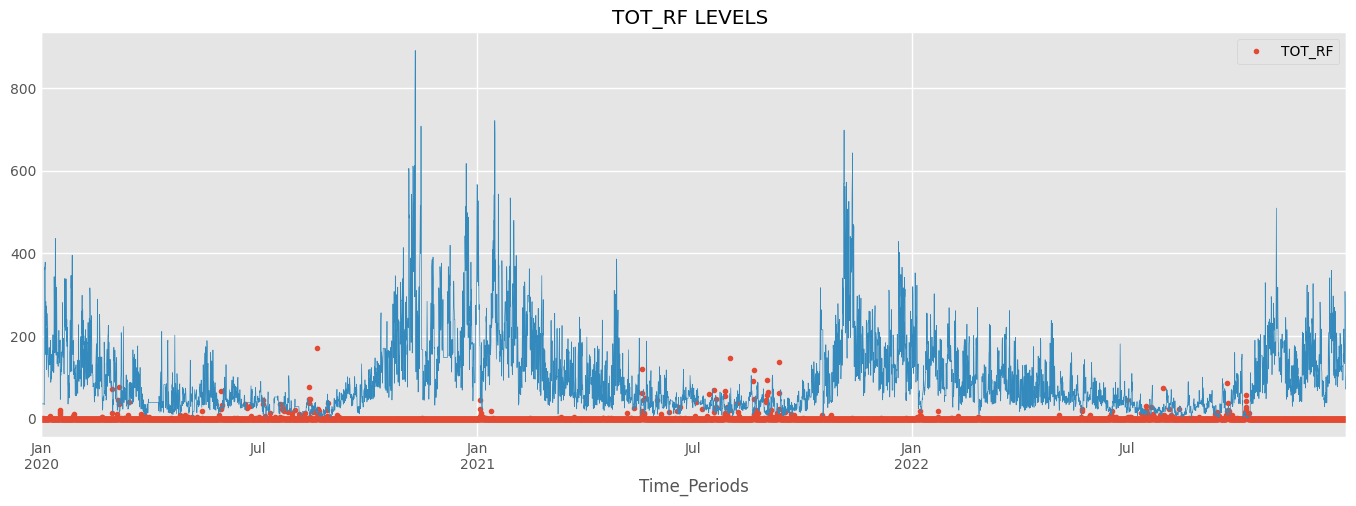

In [ ]:
for i in df_GHZ.columns:
  temp= pd.DataFrame()
  temp[i] = df_GHZ[i] 
  
  plot_element(temp)

Following features show somewhat similar trend to PM2.5


*   NOx
*   NO2
*   NO
*   NH3
*   Ozone
*   SR



In [ ]:
def eucl_dist(x,y):
  dist = (np.linalg.norm(x-y))
  print("Euclidean distance between two series ","is:", dist)

In [ ]:
for i in [ 'NO', 'NO2', 'NOx', 'NH3', 'Ozone', 'SR']:
  eucl_dist(df_GHZ.PM2_5,df_GHZ[i])

Euclidean distance between two series is: 9033.24418654369
Euclidean distance between two series is: 7656.268132082032
Euclidean distance between two series is: 7915.817743479352
Euclidean distance between two series is: 9690.762599197064
Euclidean distance between two series is: 11342.955612299751
Euclidean distance between two series is: 15666.517830244959


We can drop the remaining features from main data df_1.

In [ ]:
df_1 = df_1.drop(['SO2', 'CO', 'Benzene',
       'WS', 'WD', 'AT', 'RF', 'TOT_RF'],axis=1)

Representation of some time data

In [ ]:
df_GHZ = create_features(df_GHZ)

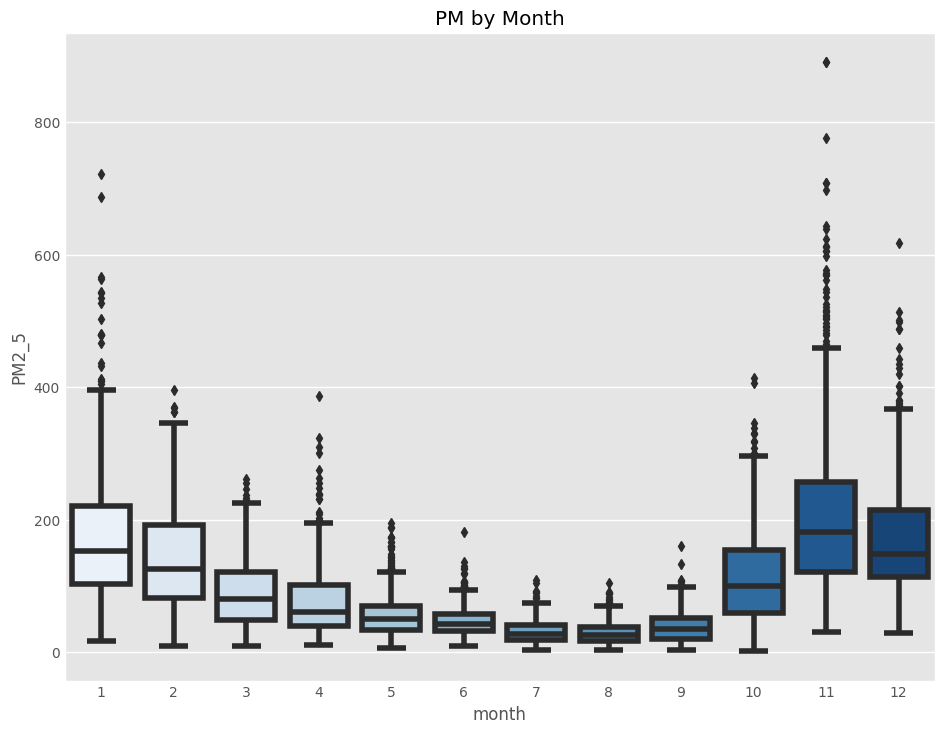

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_GHZ, x='month', y='PM2_5', palette='Blues')
ax.set_title('PM by Month')
plt.show()

There is a monthly pattern present for this particular city


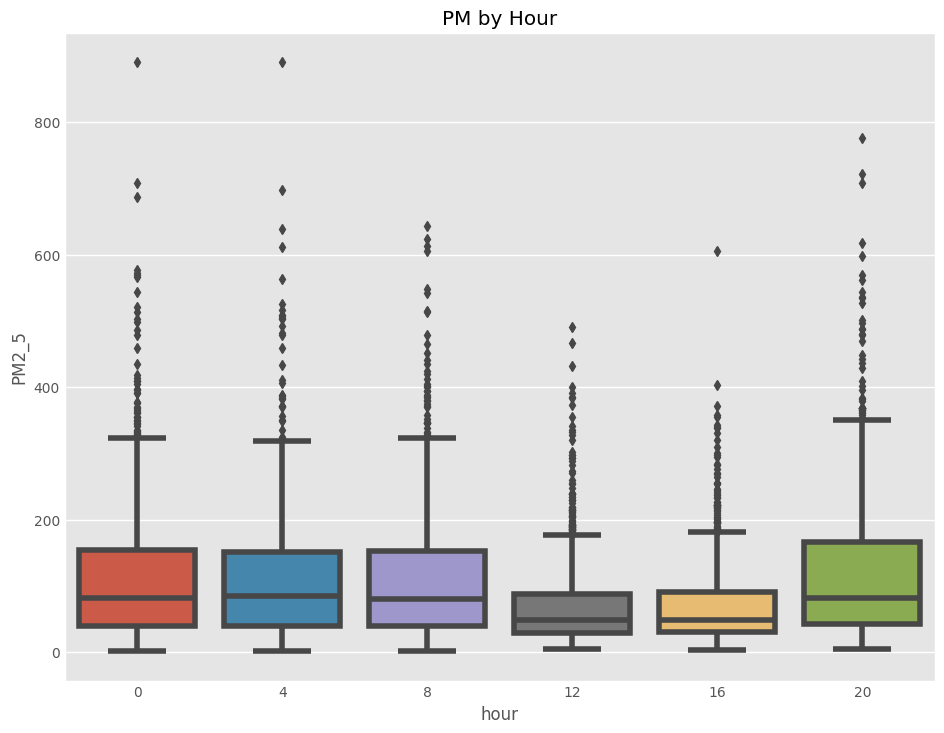

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_GHZ, x='hour', y='PM2_5')
ax.set_title('PM by Hour')
plt.show()

In [ ]:
df_1.describe()

PM2_5             NO            NO2            NOx  \
count  223583.000000  223583.000000  223583.000000  223583.000000   
mean       69.348056      14.100399      30.380630      30.775386   
std        57.218831      22.201703      31.869813      31.777418   
min         0.100000       0.010000       0.010000       0.000000   
25%        30.340937       4.000961      12.175122      13.343799   
50%        51.630955       6.736016      19.270316      21.159834   
75%        91.544772      13.314623      37.102567      35.711054   
max       890.873920     359.241357     300.479696     394.141771   

                 NH3            SO2             CO          Ozone  \
count  223583.000000  223583.000000  223583.000000  223583.000000   
mean       26.281509      13.899235       0.988644      31.241304   
std        20.499026      10.822877       0.790674      21.921284   
min         0.100000       0.010000       0.000000       0.030000   
25%        13.053931       6.332718       0.477642      14.812650   
50%        21.097037      11.294371       0.822207      27.138894   
75%        33.634157      18.810202       1.213776      42.470000   
max       412.902722     195.550000       9.472610     197.200000   

             Benzene             WS  ...   vehicles_DP           hour  \
count  223583.000000  223583.000000  ...  2.235830e+05  223583.000000   
mean        3.764795       0.996687  ...  1.305372e+06      10.000045   
std         5.805689       0.757155  ...  9.041052e+05       6.831298   
min         0.000000       0.050000  ...  1.562400e+04       0.000000   
25%         0.884419       0.547030  ...  5.686940e+05       4.000000   
50%         2.223561       0.852719  ...  1.070384e+06      12.000000   
75%         4.093864       1.261879  ...  2.555255e+06      16.000000   
max       205.880300      20.140779  ...  2.735317e+06      20.000000   

           dayofweek          month           year      dayofyear  \
count  223583.000000  223583.000000  223583.000000  223583.000000   
mean        3.001829       6.521923    2020.999092     183.167786   
std         1.997725       3.448982       0.816683     105.462549   
min         0.000000       1.000000    2020.000000       1.000000   
25%         1.000000       4.000000    2020.000000      92.000000   
50%         3.000000       7.000000    2021.000000     183.000000   
75%         5.000000      10.000000    2022.000000     274.500000   
max         6.000000      12.000000    2022.000000     366.000000   

          dayofmonth           lag1          lag2        lag3  
count  223583.000000  149328.000000  75072.000000  816.000000  
mean       15.732730      70.171901     74.129076   79.551269  
std         8.801354      30.892136     13.282722    4.757921  
min         1.000000       7.703955     42.978904   72.292424  
25%         8.000000      58.742774     69.502741   75.458147  
50%        16.000000      69.942404     70.318527   79.075138  
75%        23.000000      76.690604     72.244168   82.796296  
max        31.000000     497.722474    189.987620   90.864418  

[8 rows x 26 columns]

#Using Models

##Cross Validation


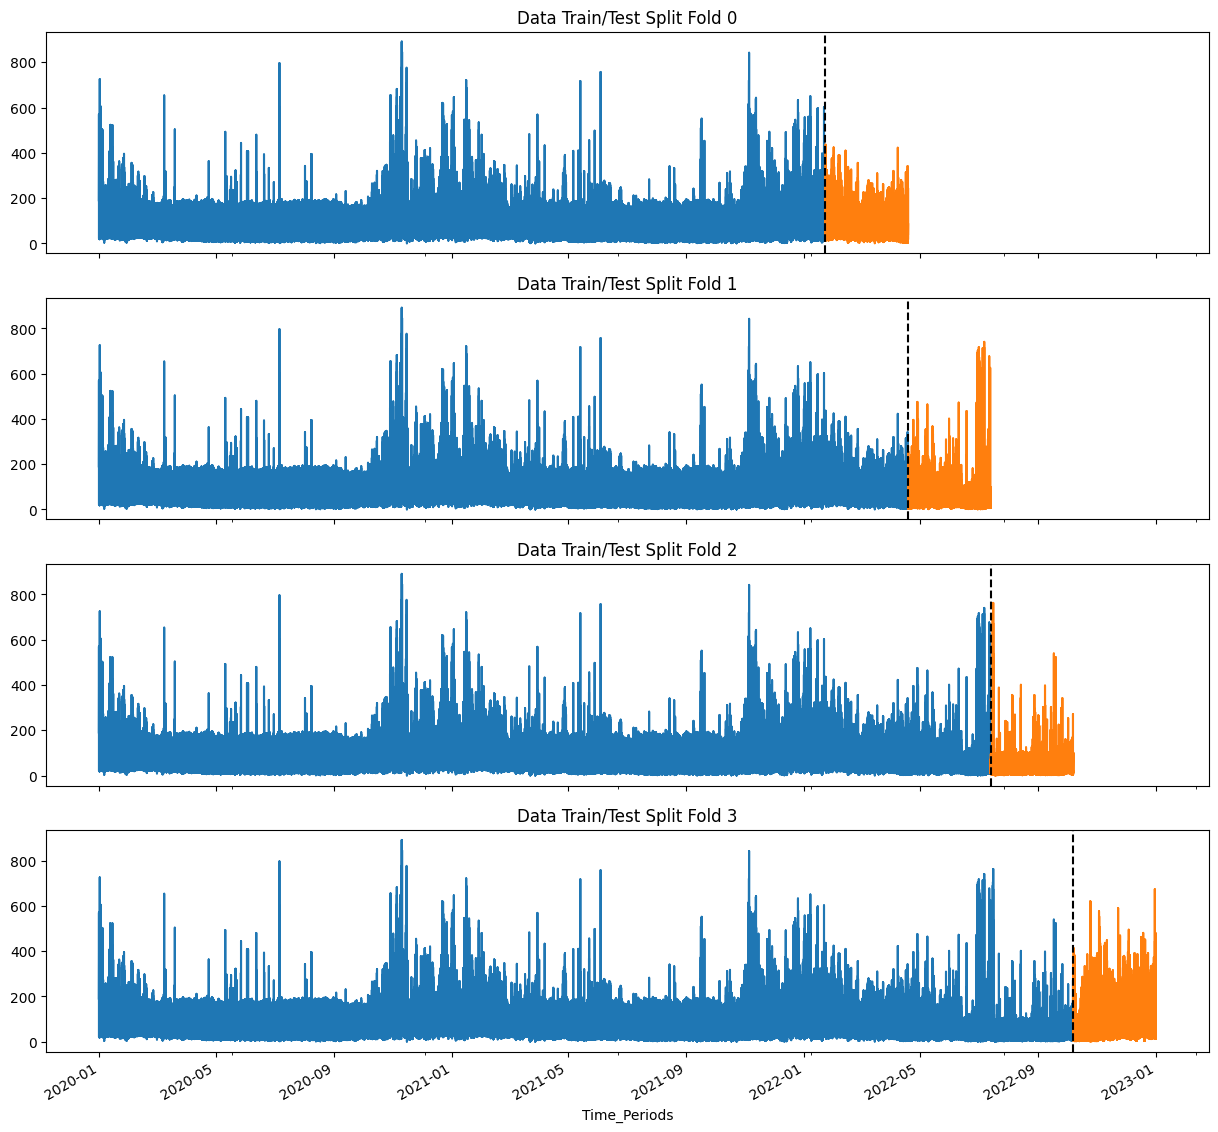

In [ ]:
#Cross validation sets representation
tss = TimeSeriesSplit(n_splits=4, test_size=24*728*1, gap=24)
df_1 = df_1.sort_index()
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df_1):
    train = df_1.iloc[train_idx]
    test = df_1.iloc[val_idx]
    train['PM2_5'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PM2_5'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
df_1.columns

Index(['PM2_5', 'NO', 'NO2', 'NOx', 'NH3', 'Ozone', 'SR', 'City',
       'vehicles_CNG', 'vehicles_DP', 'hour', 'dayofweek', 'month', 'year',
       'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3'],
      dtype='object')

In [ ]:
#Performing cross validation using all the features on whole dataset
tss = TimeSeriesSplit(n_splits=4, test_size=24*728*1, gap=24)
df_1 = df_1.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df_1):
    train = df_1.iloc[train_idx]
    test = df_1.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['NO', 'NO2', 'NOx', 'NH3', 'Ozone', 'SR',
       'vehicles_CNG', 'vehicles_DP', 'hour', 'dayofweek', 'month', 'year',
       'dayofyear', 'dayofmonth', 'lag1', 'lag2', 'lag3']
    TARGET = 'PM2_5'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]
    reg = xgb.XGBRegressor( booster='gbtree',    
                           n_estimators=200,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.05)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_absolute_percentage_error(y_test, y_pred))
    scores.append(score)

[17:59:35] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:89.54254	validation_1-rmse:84.18572
[100]	validation_0-rmse:37.00791	validation_1-rmse:40.41052
[199]	validation_0-rmse:34.72501	validation_1-rmse:39.30599
[18:00:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:89.04945	validation_1-rmse:64.63025
[100]	validation_0-rmse:37.37428	validation_1-rmse:39.69351
[199]	validation_0-rmse:35.24492	validation_1-rmse:38.51355
[18:00:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:87.12314	validation_1-rmse:42.54739
[66]	validation_0-rmse:39.35934	validation_1-rmse:31.11586
[18:00:43] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:84.33142	validation_1-rmse:10

In [ ]:
scores

[0.7555565565932755, 0.8476455720278244, 0.8803276071786381, 0.852783504915338]

In [ ]:
np.mean(scores)

0.8340783101787691

##XGBoost - only using time series data

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
regressor = xgb.XGBRegressor()

In [ ]:
FEATURES = ['hour', 'dayofweek', 'month',
            'year', 'dayofyear', 'dayofmonth', 'lag1', 'lag2',
            'lag3']
TARGET   = 'PM2_5'

###Finding appropriate Hyperparameter 

In [ ]:
hpset1 = df_1[FEATURES]
hpset2 = df_1[TARGET]

In [ ]:
hyperparameter_grid = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }

random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=3, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [ ]:
random_cv.fit(hpset1,hpset2)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=None,
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=50, n_jobs=4,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 6, 9],
                                        'min_child_weight': [1, 10, 100],
                                        'n_estimators': [100, 400, 800]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

In [ ]:
best = random_cv.best_estimator_
best.save_model('best.json')

###Train and Test

In [ ]:
#list to store mean absolute percentage error from each city
res = []


#Function to plot predicted values vs actual
def prediction_plot(df_city,reg,x_test,y_test):
  test = pd.DataFrame()
  x_test['prediction'] = reg.predict(x_test[FEATURES])

  df_city = df_city.merge(x_test[['prediction']], how='left', left_index=True, right_index=True)
  
  ax = df_city[['PM2_5']].plot(figsize=(15, 5))
  df_city['prediction'].plot(ax=ax)
  plt.legend(['Truth Data', 'Predictions'])
  ax.set_title('Raw Data and Prediction')
  
  plt.show()

  res.append(mean_absolute_percentage_error(x_test['prediction'],y_test))

 

Training started for  Bengaluru  --------
[18:20:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:43.57664
[100]	validation_0-rmse:24.89885
[200]	validation_0-rmse:25.76366
[300]	validation_0-rmse:26.78603
[400]	validation_0-rmse:27.33406
[499]	validation_0-rmse:27.46602


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


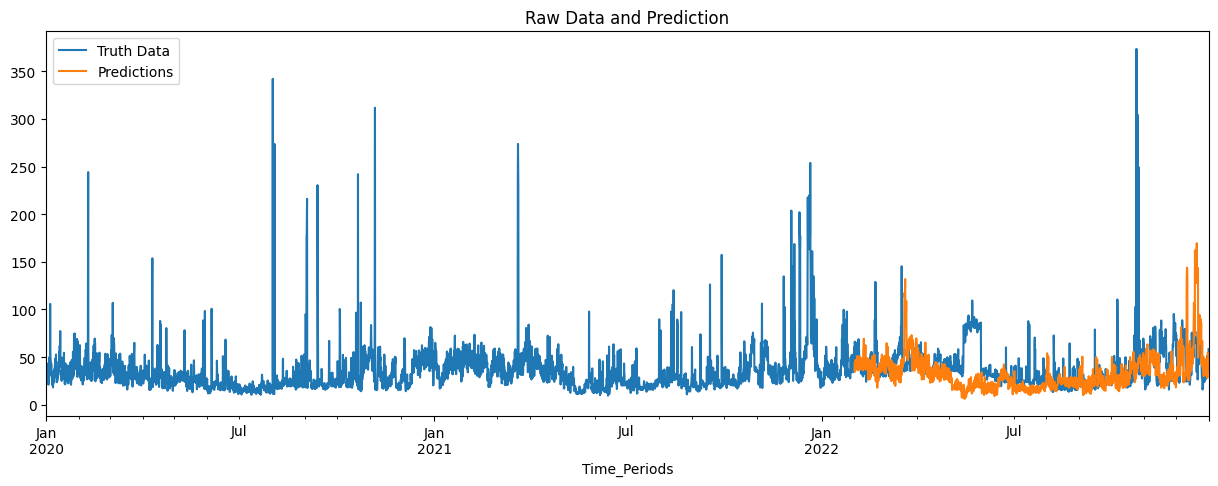

Training started for  Muzaffarpur  --------
[18:20:07] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:106.17639
[100]	validation_0-rmse:68.48498
[200]	validation_0-rmse:78.27349
[300]	validation_0-rmse:79.15236
[400]	validation_0-rmse:80.50037
[499]	validation_0-rmse:77.81627


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


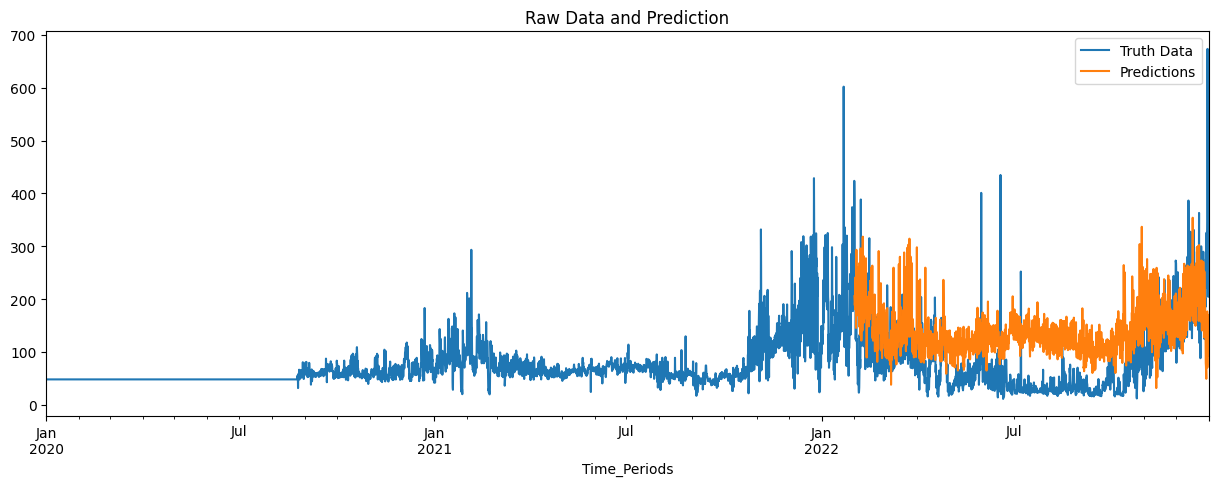

Training started for  Ahmedabad  --------
[18:20:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:64.34112
[100]	validation_0-rmse:48.76599
[200]	validation_0-rmse:50.97545
[300]	validation_0-rmse:52.15667
[400]	validation_0-rmse:52.54788
[499]	validation_0-rmse:52.98743


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


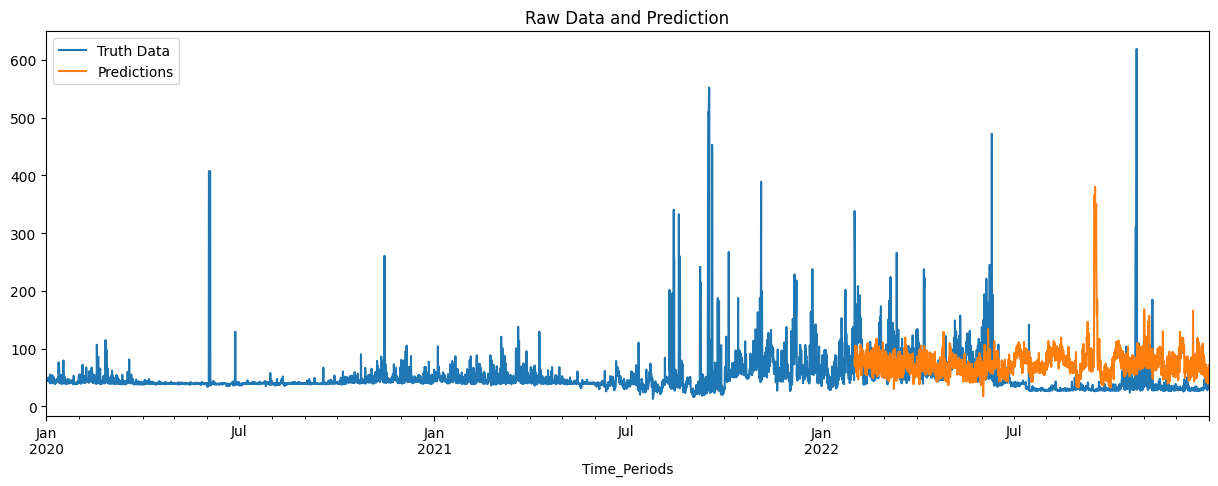

Training started for  Kota  --------
[18:20:10] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:64.44036
[100]	validation_0-rmse:32.47884
[200]	validation_0-rmse:35.57235
[300]	validation_0-rmse:36.99988
[400]	validation_0-rmse:37.88739
[499]	validation_0-rmse:38.98451


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


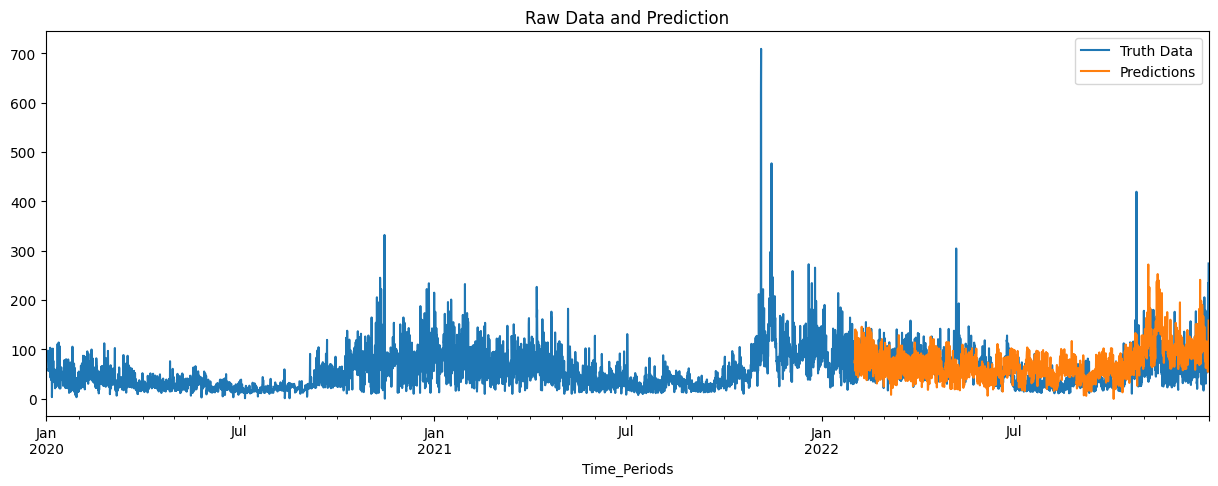

Training started for  Howrah  --------
[18:20:12] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:76.38849
[100]	validation_0-rmse:33.32085
[200]	validation_0-rmse:33.94459
[300]	validation_0-rmse:35.83063
[400]	validation_0-rmse:36.86007
[499]	validation_0-rmse:38.88720


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


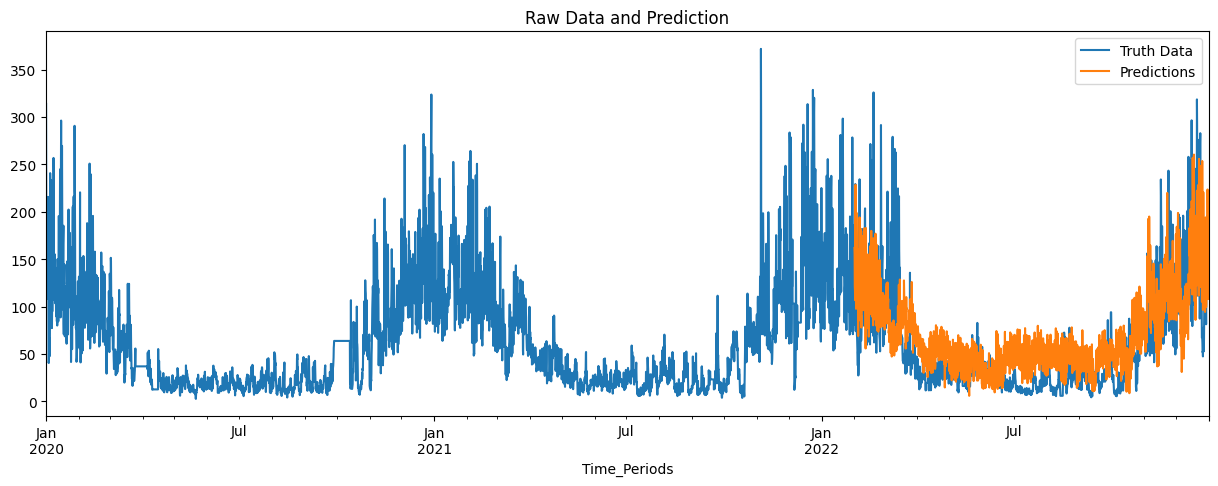

Training started for  Gandhinagar  --------
[18:20:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:63.91745
[100]	validation_0-rmse:125.66814
[200]	validation_0-rmse:129.28931
[300]	validation_0-rmse:127.03479
[400]	validation_0-rmse:125.21764
[499]	validation_0-rmse:124.67477


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


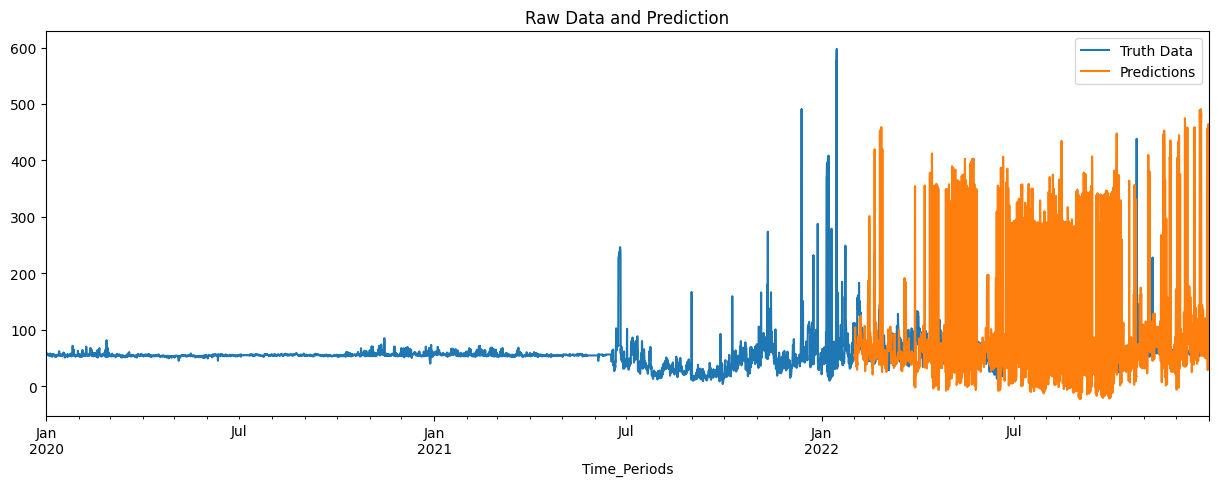

Training started for  Faridabad  --------
[18:20:17] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:118.43787
[100]	validation_0-rmse:67.36455
[200]	validation_0-rmse:68.22314
[300]	validation_0-rmse:68.37985
[400]	validation_0-rmse:69.04151
[499]	validation_0-rmse:69.62249


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


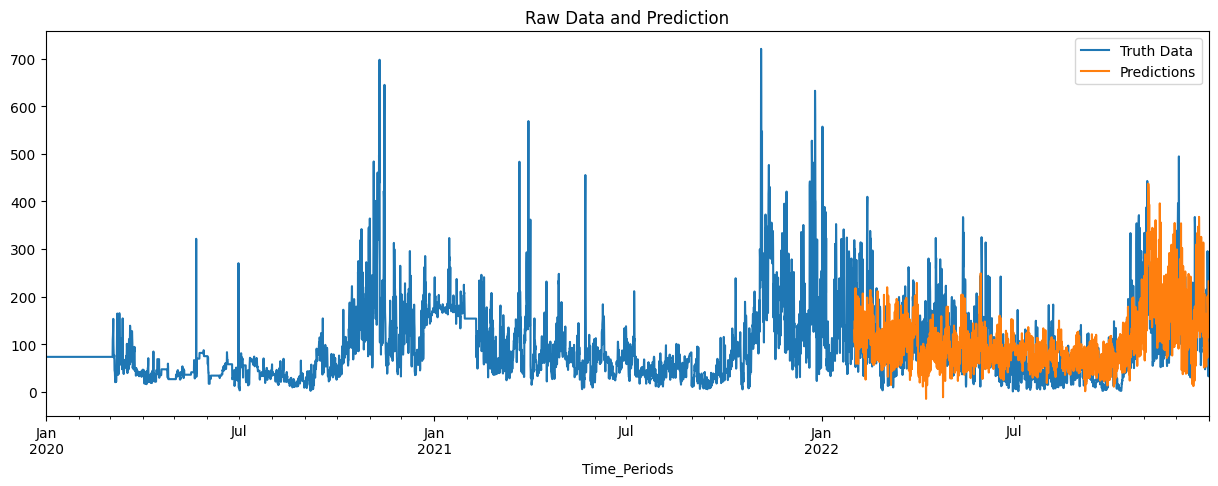

Training started for  Noida  --------
[18:20:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:89.25932
[100]	validation_0-rmse:53.33181
[200]	validation_0-rmse:54.96508
[300]	validation_0-rmse:55.87038
[400]	validation_0-rmse:56.63020
[499]	validation_0-rmse:56.80112


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


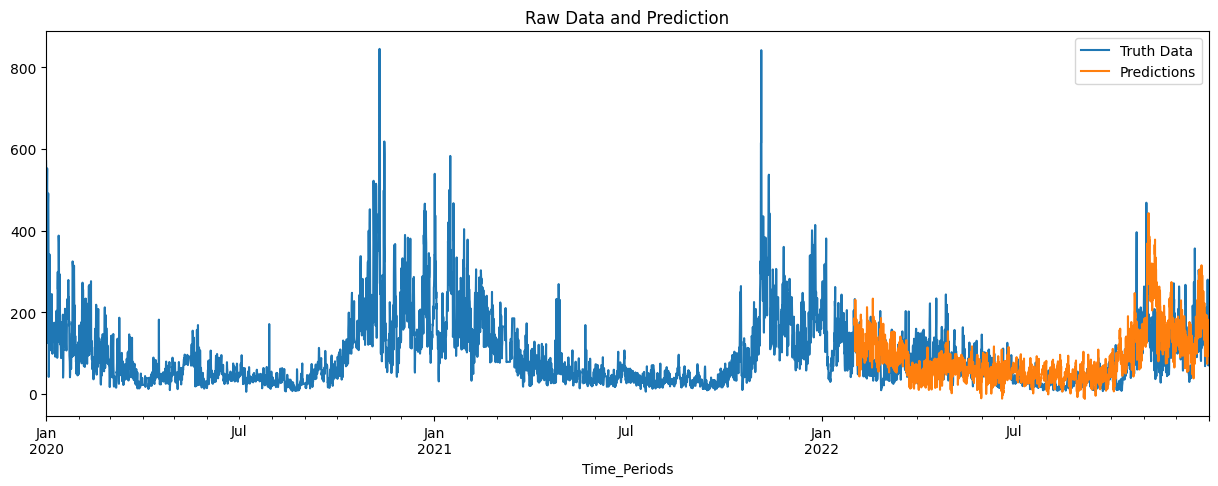

Training started for  Gurugram  --------
[18:20:23] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:109.15151
[100]	validation_0-rmse:53.79022
[200]	validation_0-rmse:56.93656
[300]	validation_0-rmse:59.92325
[400]	validation_0-rmse:62.17130
[499]	validation_0-rmse:63.39843


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


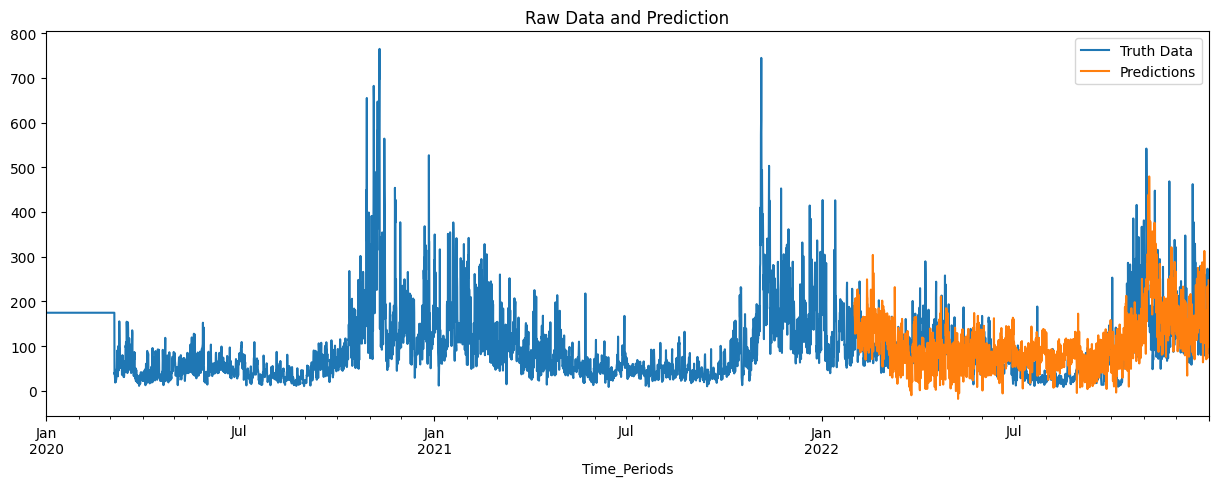

Training started for  Chennai  --------
[18:20:24] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:37.21179
[100]	validation_0-rmse:43.84507
[200]	validation_0-rmse:45.54012
[300]	validation_0-rmse:46.51017
[400]	validation_0-rmse:46.86772
[499]	validation_0-rmse:47.30521


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


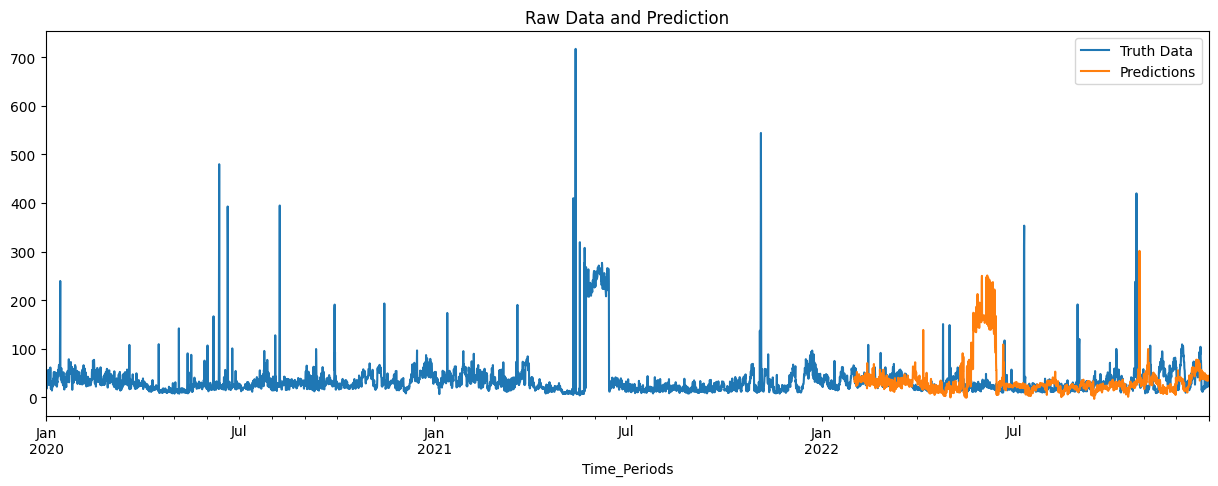

Training started for  Bhilai  --------
[18:20:28] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:33.68038
[100]	validation_0-rmse:11.11740
[200]	validation_0-rmse:11.09640
[300]	validation_0-rmse:11.10497
[400]	validation_0-rmse:11.08839
[499]	validation_0-rmse:11.06524


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


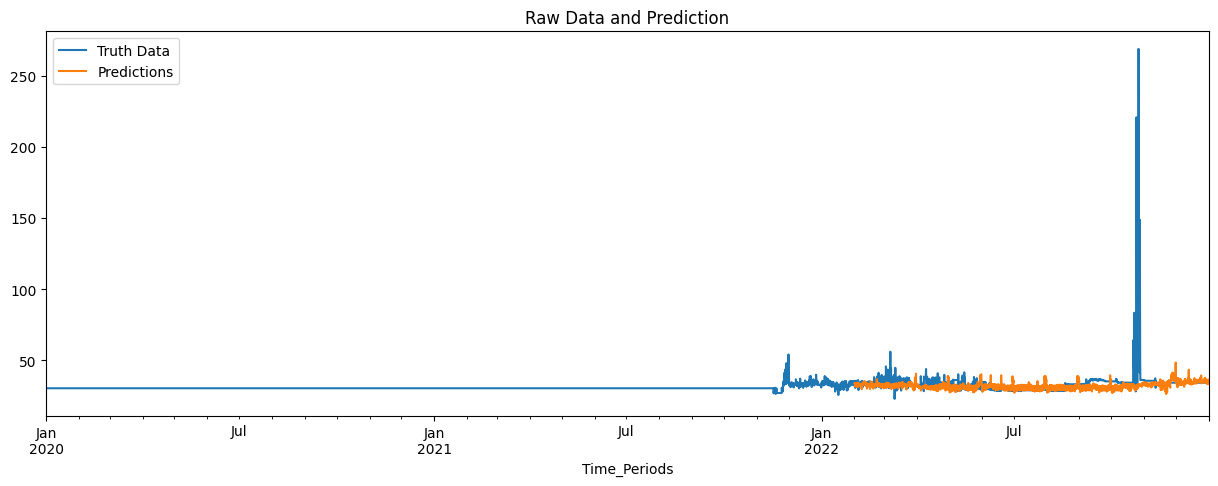

Training started for  Raipur  --------
[18:20:30] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:46.87886
[100]	validation_0-rmse:2.23179
[200]	validation_0-rmse:2.14915
[300]	validation_0-rmse:2.14876
[400]	validation_0-rmse:2.14876
[499]	validation_0-rmse:2.14876


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


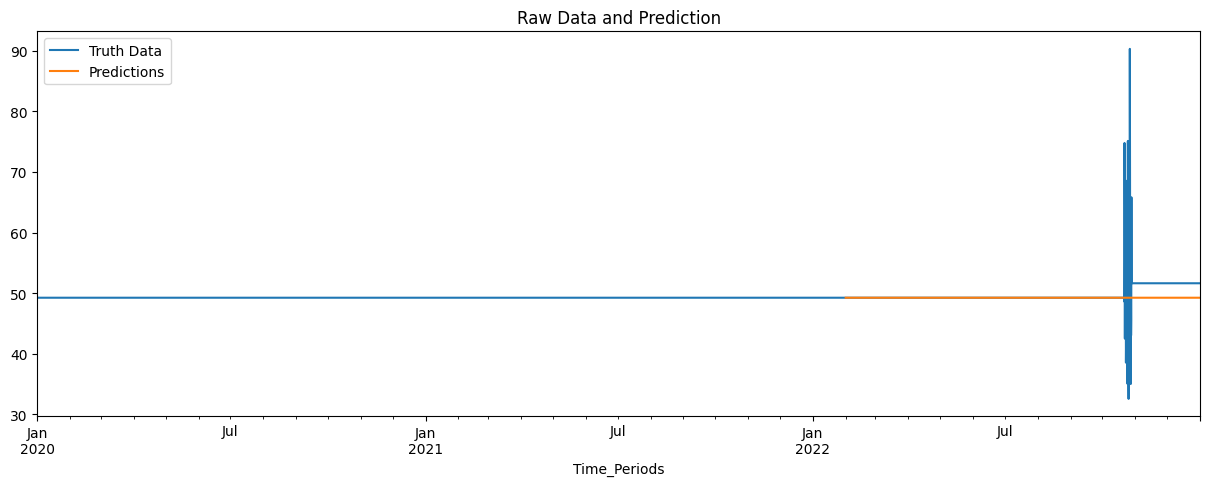

Training started for  Bhopal  --------
[18:20:31] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:57.39441
[100]	validation_0-rmse:32.03221
[200]	validation_0-rmse:33.86866
[300]	validation_0-rmse:34.42989
[400]	validation_0-rmse:33.39642
[499]	validation_0-rmse:33.78037


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


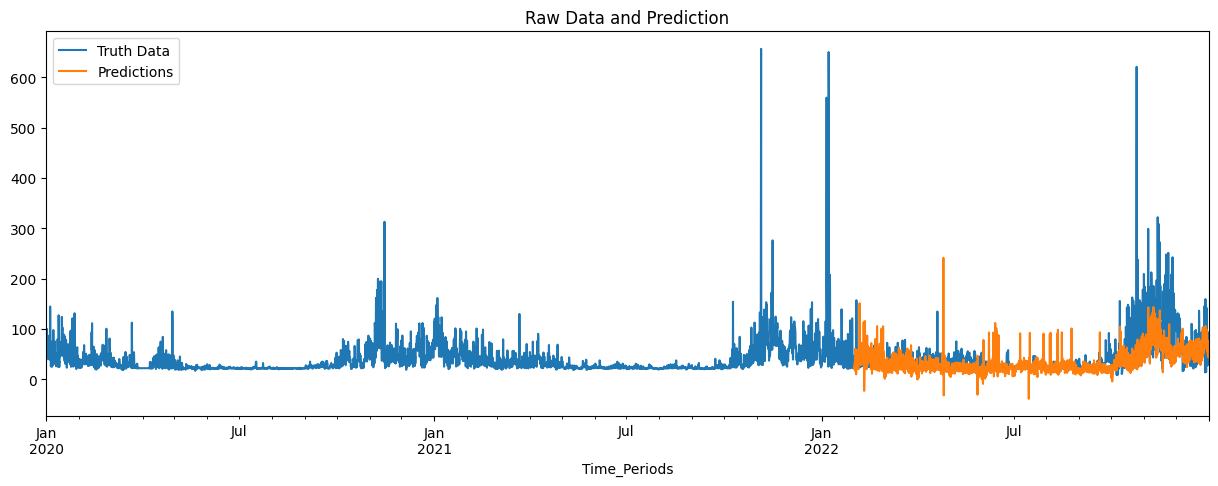

Training started for  Prayagraj  --------
[18:20:33] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:46.55411
[100]	validation_0-rmse:37.76117
[200]	validation_0-rmse:39.60842
[300]	validation_0-rmse:41.29473
[400]	validation_0-rmse:42.19129
[499]	validation_0-rmse:41.36245


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


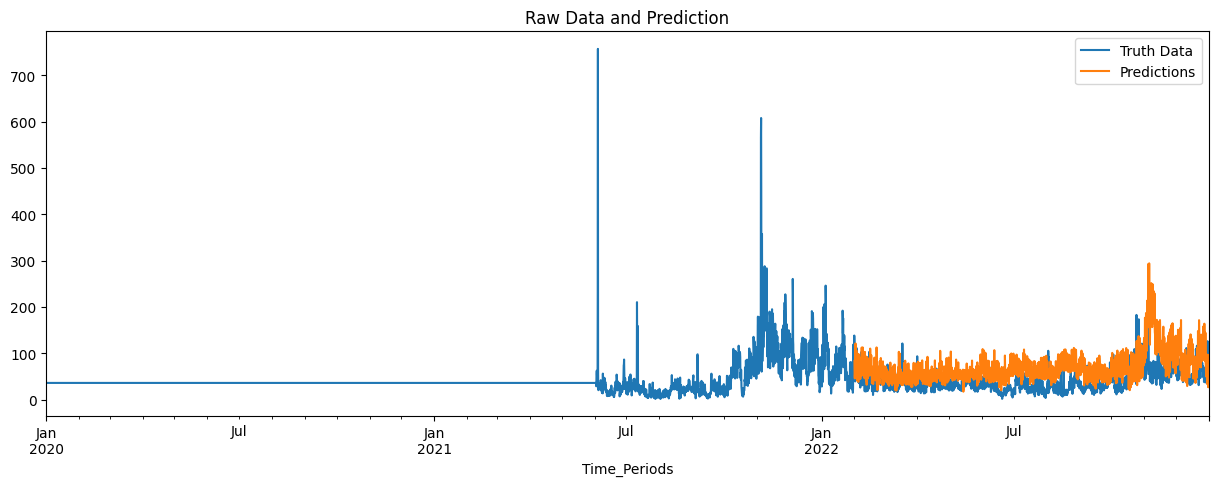

Training started for  Gwalior  --------
[18:20:34] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:106.80038
[100]	validation_0-rmse:28.42762
[200]	validation_0-rmse:28.54468
[300]	validation_0-rmse:28.88486
[400]	validation_0-rmse:29.09784
[499]	validation_0-rmse:29.16908


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


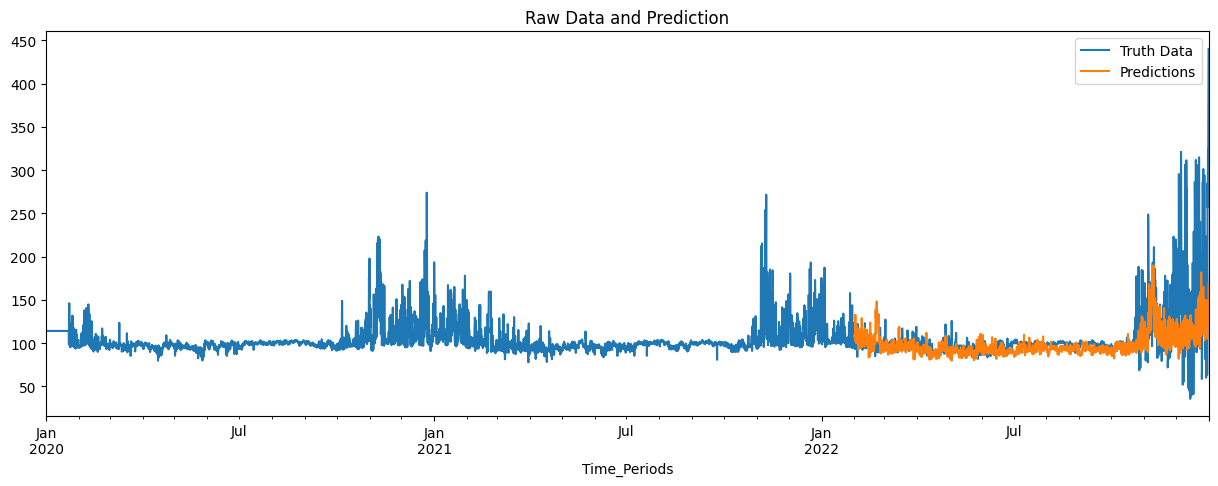

Training started for  Mumbai  --------
[18:20:36] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:114.12561
[100]	validation_0-rmse:85.46526
[200]	validation_0-rmse:86.48163
[300]	validation_0-rmse:86.63006
[400]	validation_0-rmse:86.72229
[499]	validation_0-rmse:86.85991


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


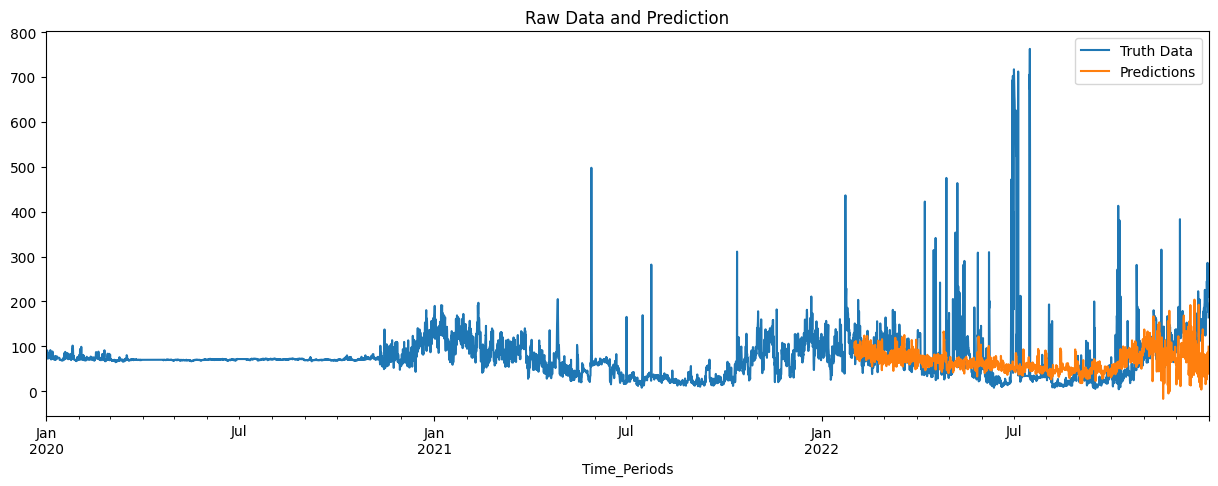

Training started for  Delhi  --------
[18:20:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:133.90610
[100]	validation_0-rmse:66.56767
[200]	validation_0-rmse:70.65364
[300]	validation_0-rmse:71.28889
[400]	validation_0-rmse:70.85020
[499]	validation_0-rmse:70.30929


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


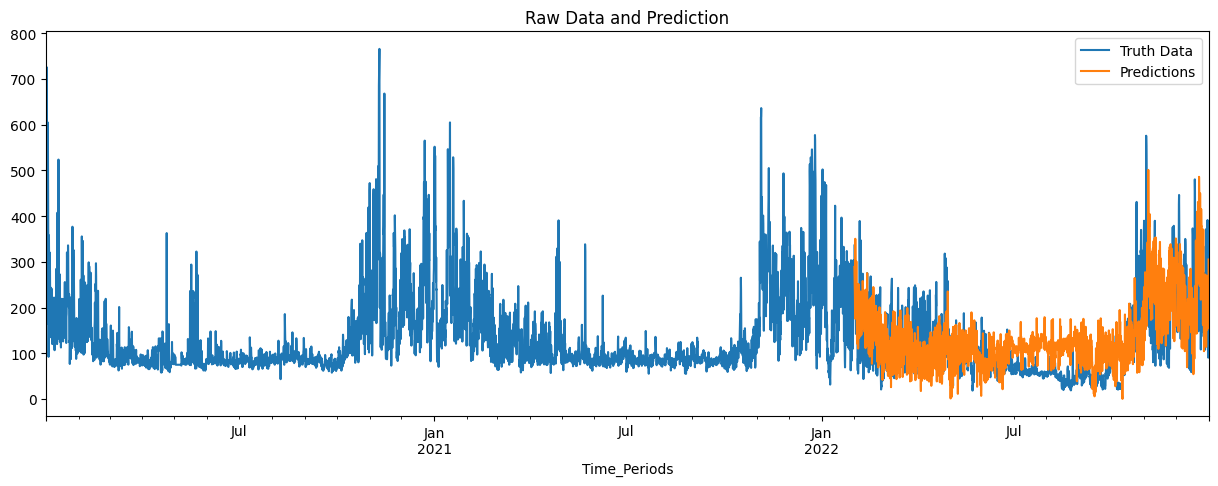

Training started for  Moradabad  --------
[18:20:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:55.97920
[100]	validation_0-rmse:40.53547
[200]	validation_0-rmse:43.26300
[300]	validation_0-rmse:45.19594
[400]	validation_0-rmse:46.47627
[499]	validation_0-rmse:47.24915


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


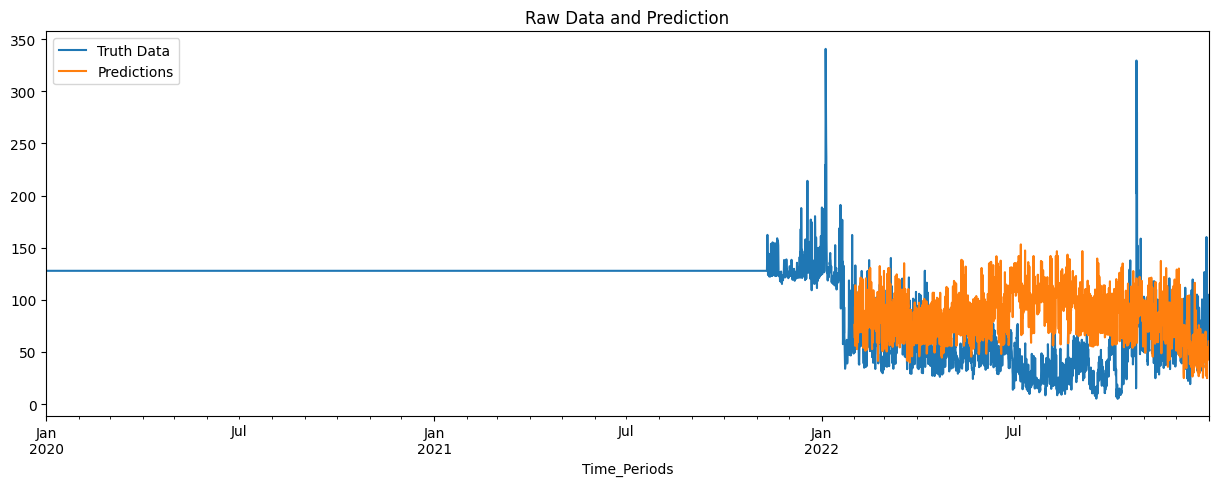

Training started for  Imphal  --------
[18:20:44] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:36.99479
[100]	validation_0-rmse:28.54752
[200]	validation_0-rmse:28.54833
[300]	validation_0-rmse:28.54834
[400]	validation_0-rmse:28.54834
[499]	validation_0-rmse:28.54834


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


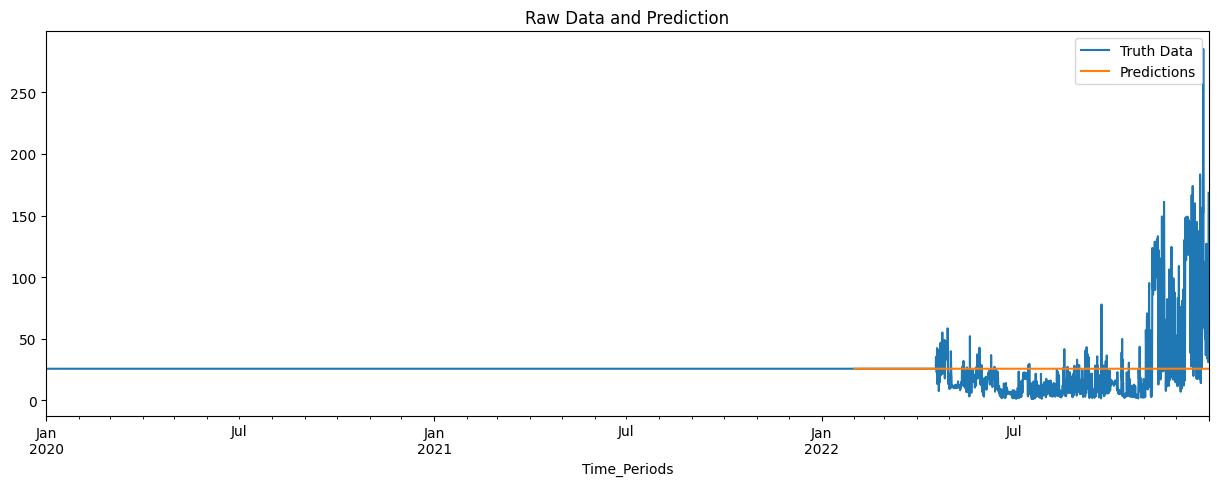

Training started for  Kolkata  --------
[18:20:46] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:58.39092
[100]	validation_0-rmse:23.22710
[200]	validation_0-rmse:24.60947
[300]	validation_0-rmse:25.50997
[400]	validation_0-rmse:26.04267
[499]	validation_0-rmse:26.80206


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


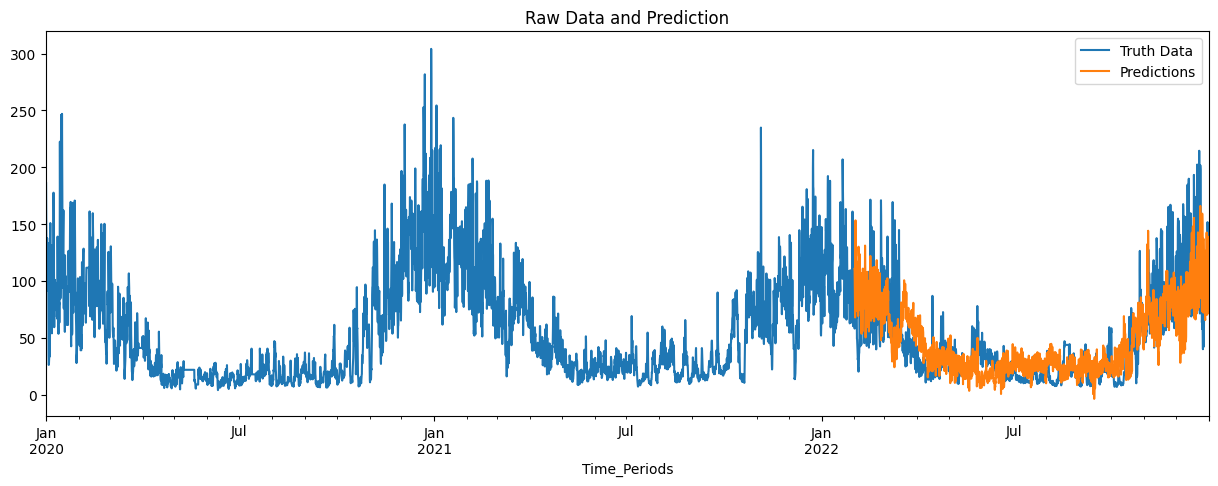

Training started for  Guwahati  --------
[18:20:55] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:82.38327
[100]	validation_0-rmse:15.36884
[200]	validation_0-rmse:17.63232
[300]	validation_0-rmse:19.34077
[400]	validation_0-rmse:20.09762
[499]	validation_0-rmse:20.70855


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


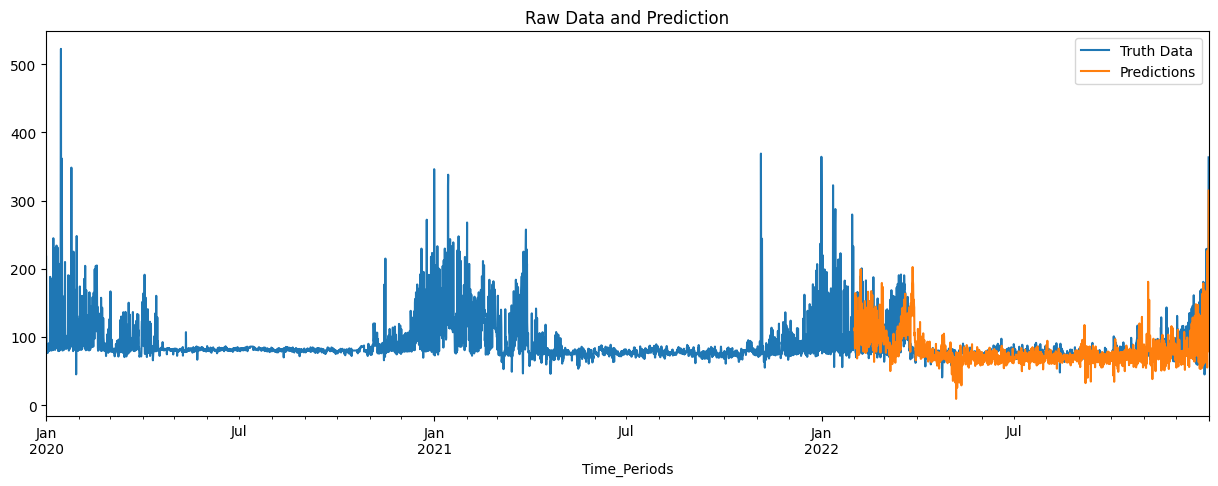

Training started for  Ghaziabad  --------
[18:20:57] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:96.77670
[100]	validation_0-rmse:54.01117
[200]	validation_0-rmse:56.88379
[300]	validation_0-rmse:58.62121
[400]	validation_0-rmse:59.38244
[499]	validation_0-rmse:59.90080


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


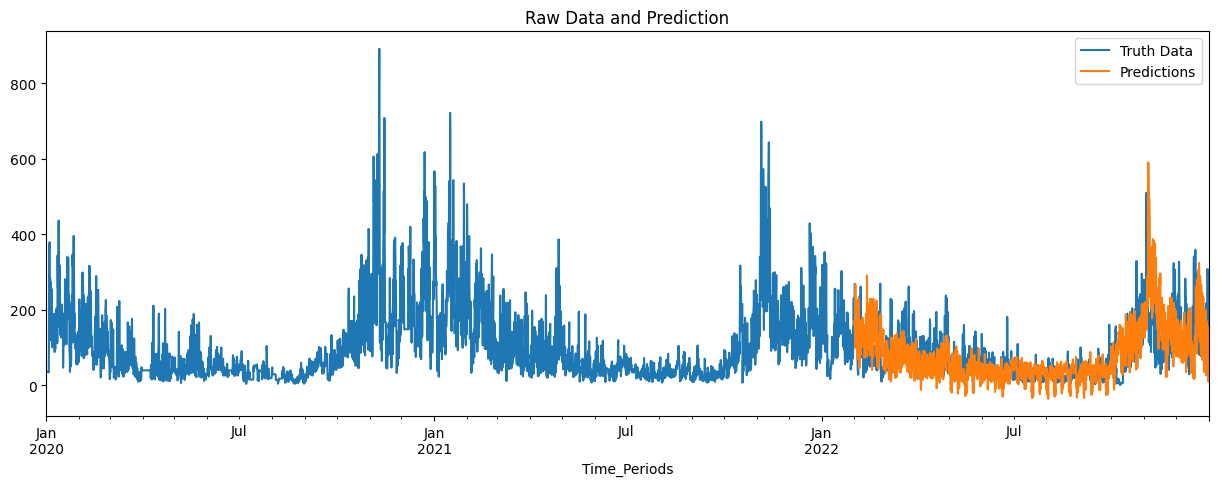

Training started for  Varanasi  --------
[18:20:58] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:40.25613
[100]	validation_0-rmse:24.61859
[200]	validation_0-rmse:24.48322
[300]	validation_0-rmse:25.02281
[400]	validation_0-rmse:25.39110
[499]	validation_0-rmse:25.75511


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


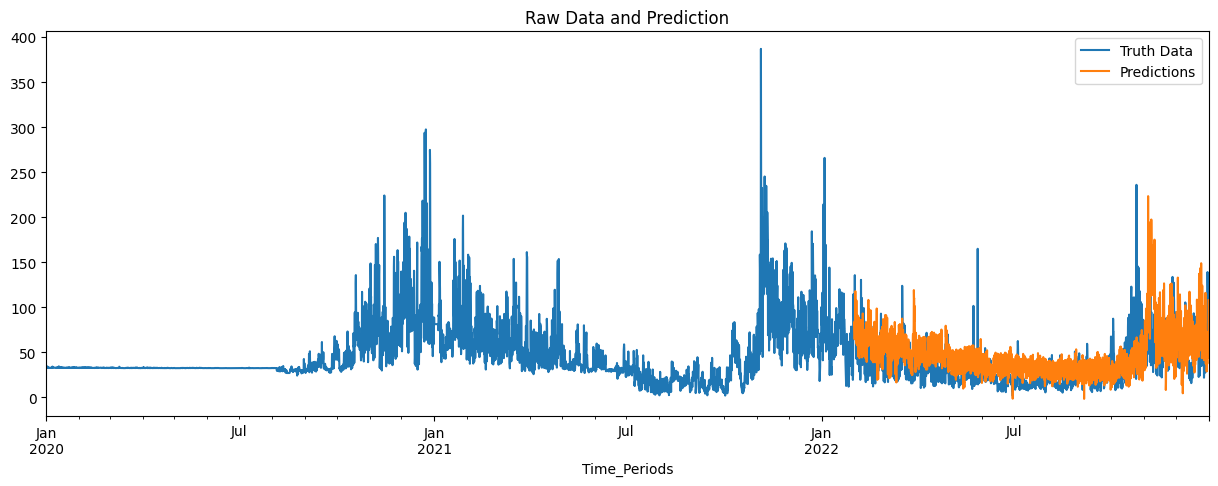

Training started for  Thiruvananthapuram  --------
[18:21:00] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:35.88099
[100]	validation_0-rmse:23.14944
[200]	validation_0-rmse:23.81082
[300]	validation_0-rmse:24.22016
[400]	validation_0-rmse:24.60480
[499]	validation_0-rmse:24.86124


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


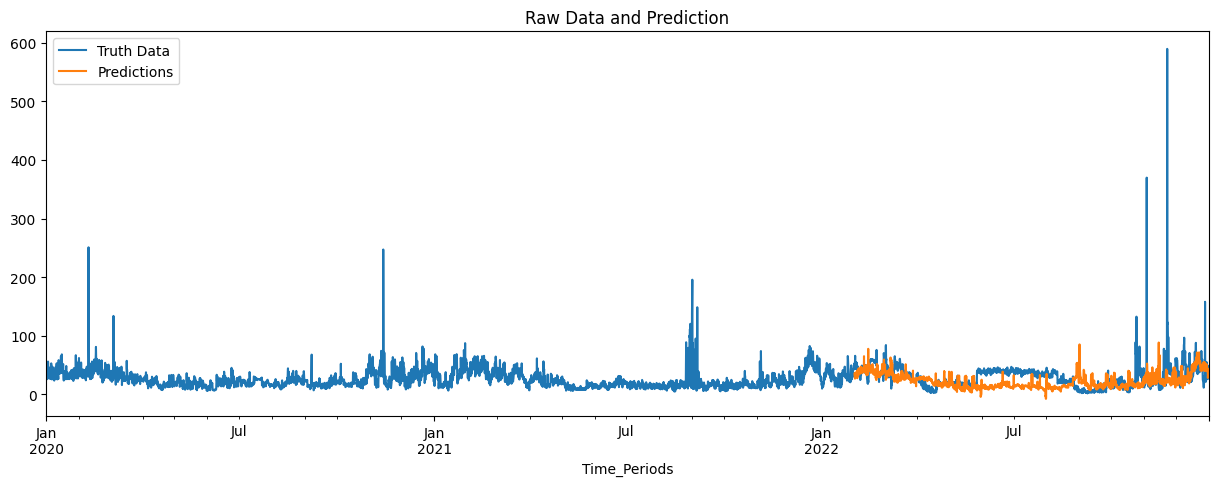

Training started for  Patna  --------
[18:21:02] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:106.54745
[100]	validation_0-rmse:52.07733
[200]	validation_0-rmse:50.31051
[300]	validation_0-rmse:50.47003
[400]	validation_0-rmse:50.83605
[499]	validation_0-rmse:51.23778


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


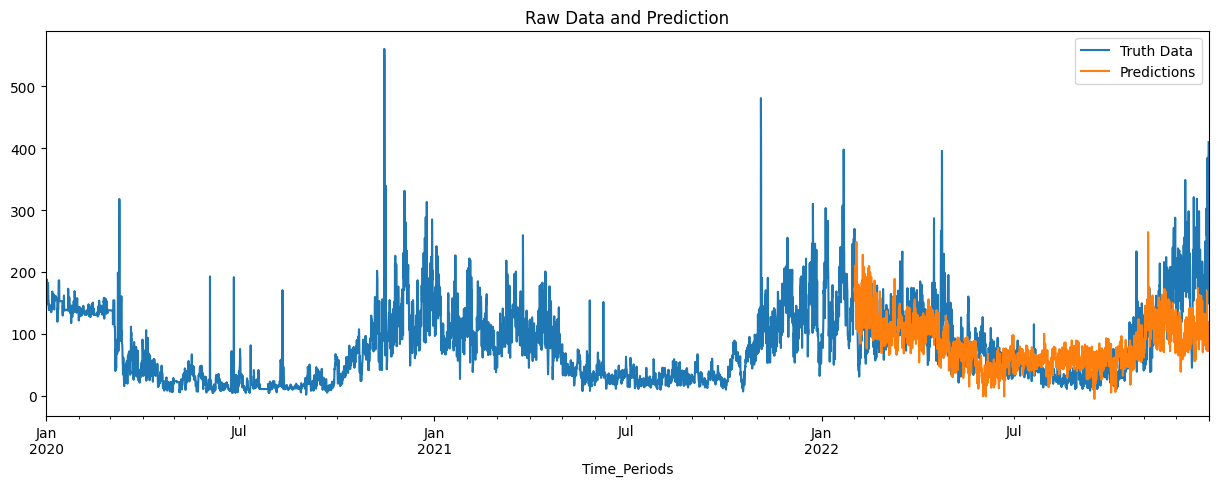

Training started for  Lucknow  --------
[18:21:04] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:74.49109
[100]	validation_0-rmse:35.08325
[200]	validation_0-rmse:35.22384
[300]	validation_0-rmse:36.27757
[400]	validation_0-rmse:37.23758
[499]	validation_0-rmse:38.09942


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


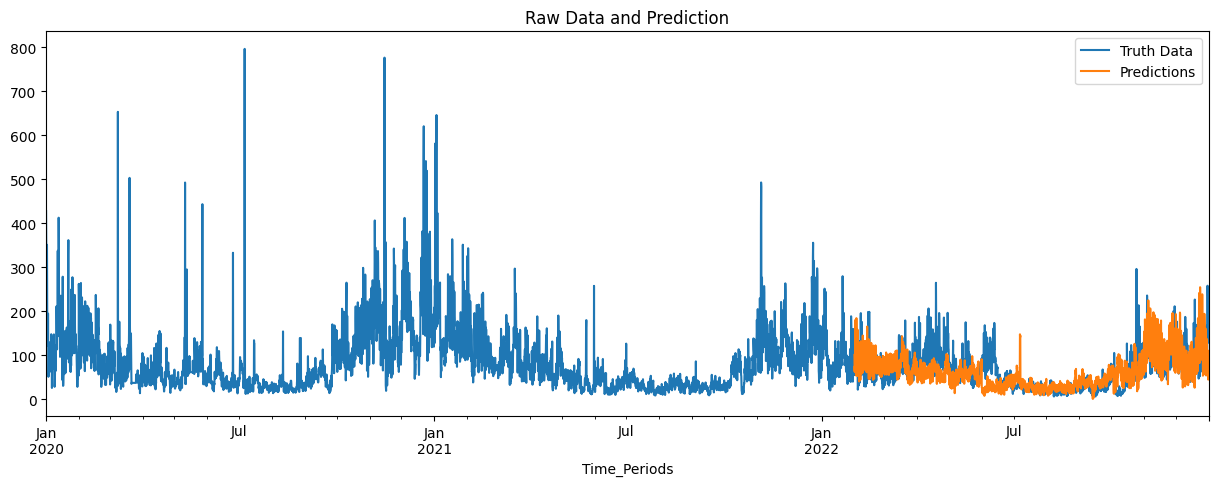

Training started for  Agartala  --------
[18:21:08] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:60.74356
[100]	validation_0-rmse:48.54678
[200]	validation_0-rmse:49.93569
[300]	validation_0-rmse:50.29936
[400]	validation_0-rmse:50.37799
[499]	validation_0-rmse:50.69607


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


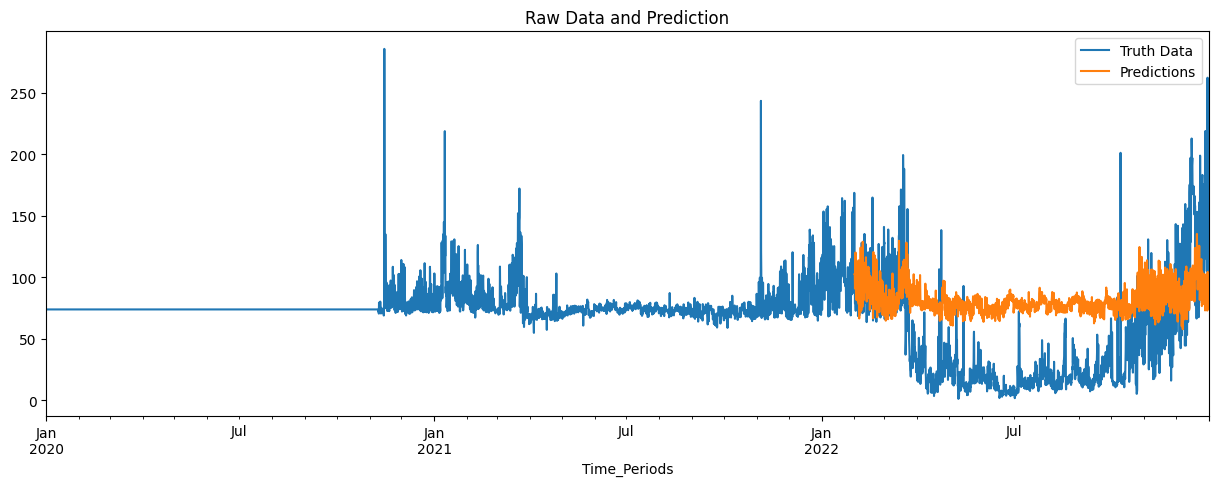

Training started for  Meerut  --------
[18:21:09] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:88.65223
[100]	validation_0-rmse:50.81806
[200]	validation_0-rmse:54.93876
[300]	validation_0-rmse:56.57221
[400]	validation_0-rmse:57.00452
[499]	validation_0-rmse:58.82628


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


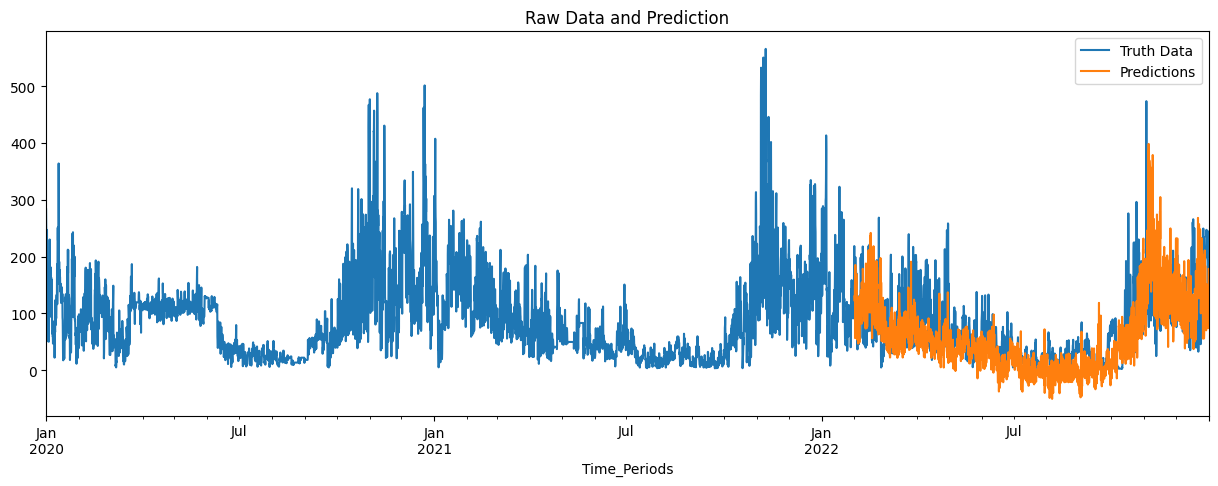

Training started for  Gaya  --------
[18:21:11] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:108.50045
[100]	validation_0-rmse:74.55504
[200]	validation_0-rmse:75.85093
[300]	validation_0-rmse:76.38495
[400]	validation_0-rmse:77.56296
[499]	validation_0-rmse:79.42082


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


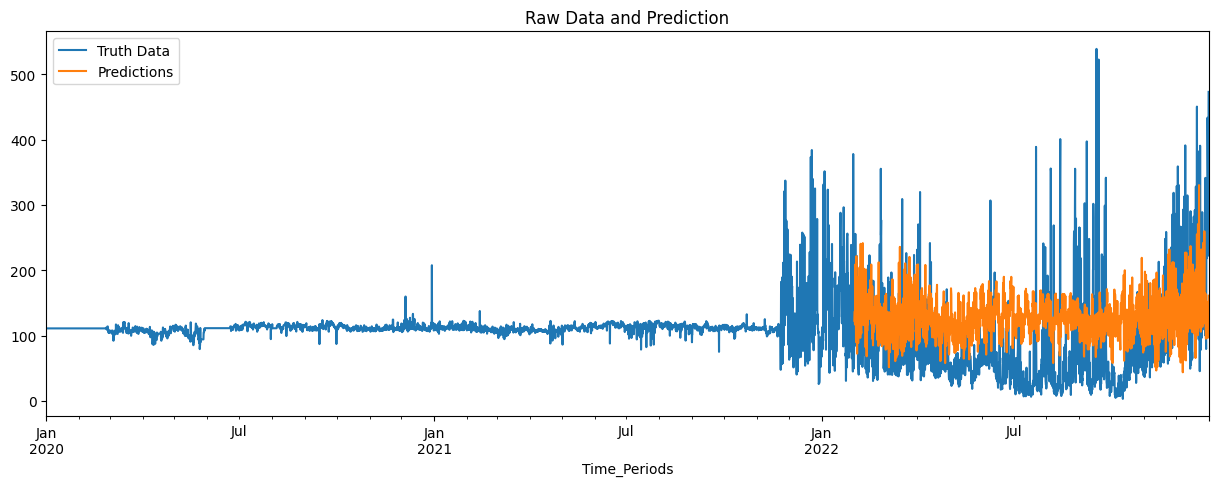

Training started for  Kanpur  --------
[18:21:13] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:66.27944
[100]	validation_0-rmse:33.39504
[200]	validation_0-rmse:35.56542
[300]	validation_0-rmse:35.72147
[400]	validation_0-rmse:35.55754
[499]	validation_0-rmse:35.74964


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


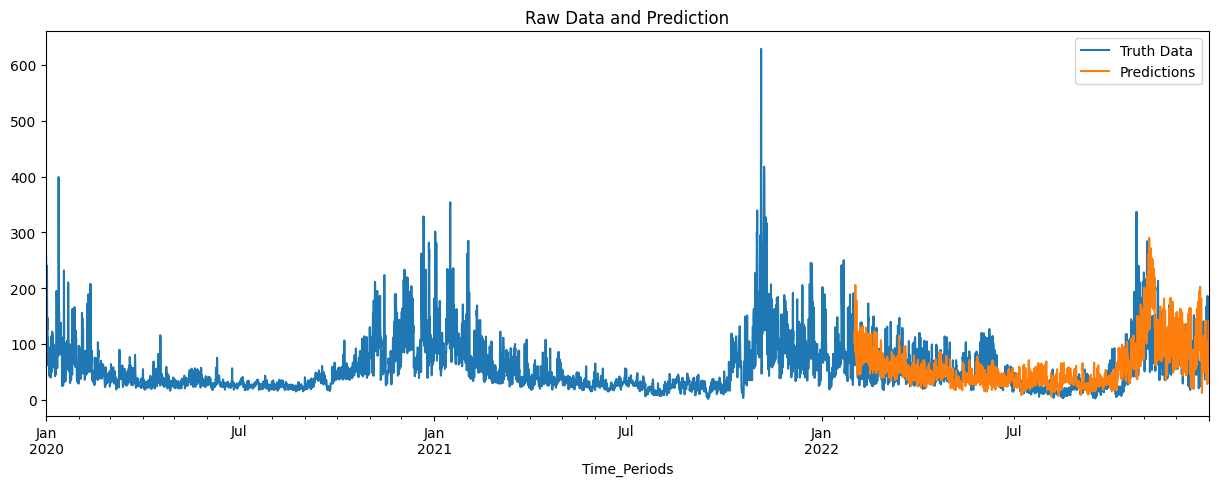

Training started for  Agra  --------
[18:21:15] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:60.36867
[100]	validation_0-rmse:54.31053
[200]	validation_0-rmse:57.66628
[300]	validation_0-rmse:58.76738
[400]	validation_0-rmse:59.19499
[499]	validation_0-rmse:59.99378


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


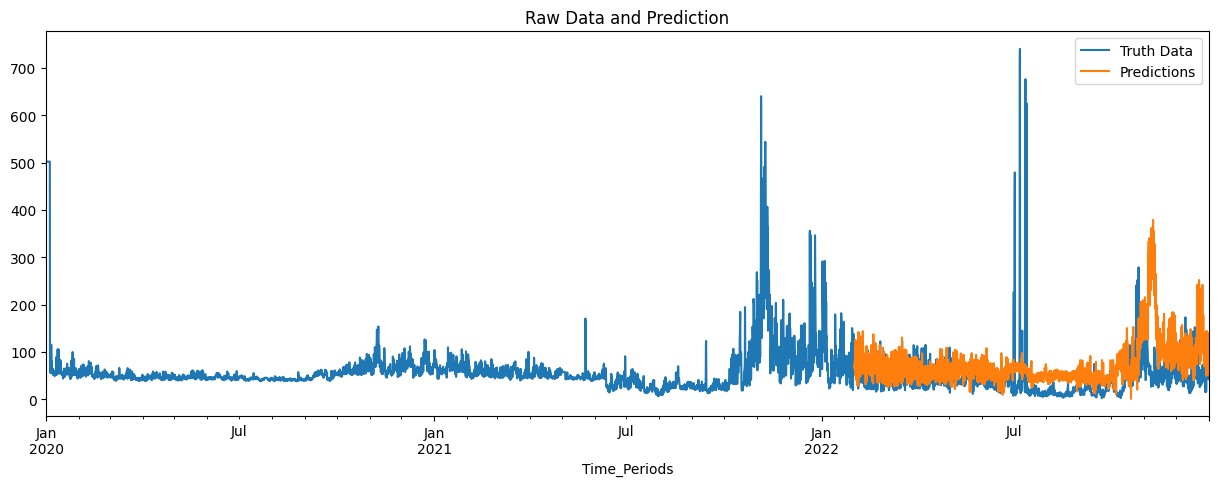

Training started for  Srinagar  --------
[18:21:16] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32.22885
[100]	validation_0-rmse:22.66905
[200]	validation_0-rmse:23.26314
[300]	validation_0-rmse:24.47232
[400]	validation_0-rmse:25.11594
[499]	validation_0-rmse:25.45977


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


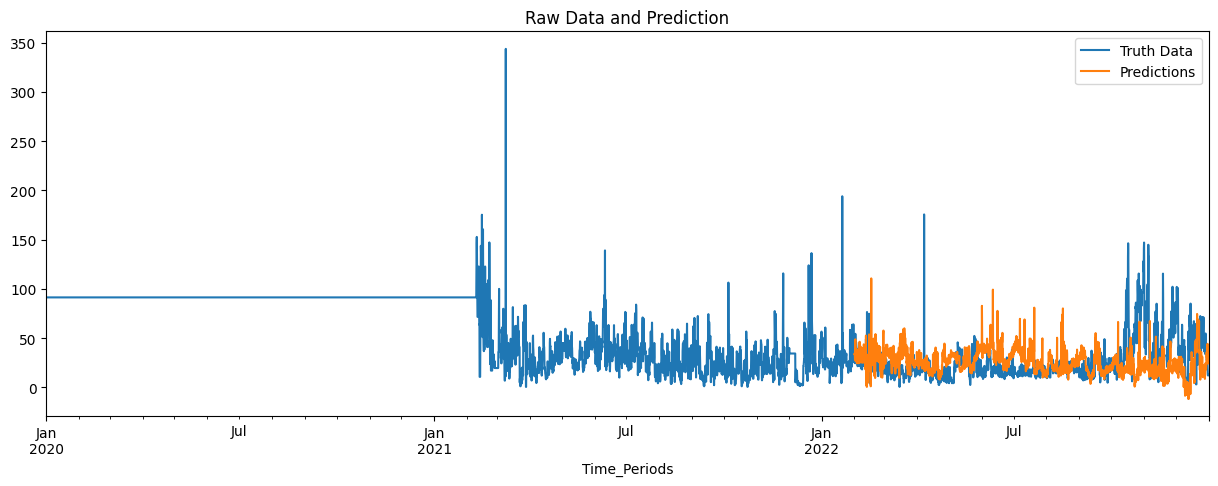

Training started for  Chandigarh  --------
[18:21:20] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:64.13030
[100]	validation_0-rmse:114.17784
[200]	validation_0-rmse:115.23289
[300]	validation_0-rmse:115.43627
[400]	validation_0-rmse:115.54832
[499]	validation_0-rmse:115.12653


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


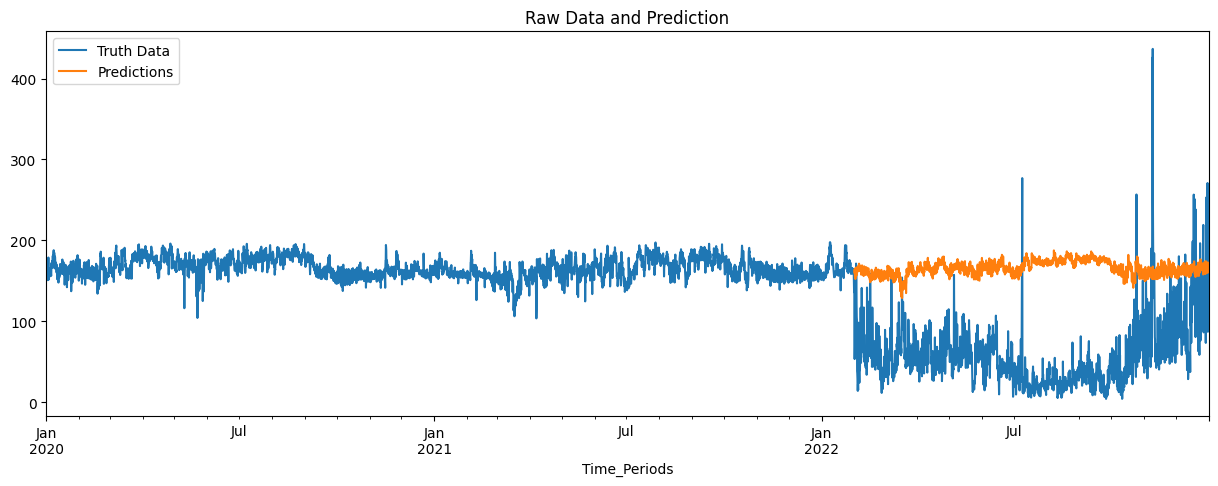

Training started for  Jaipur  --------
[18:21:22] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:67.04475
[100]	validation_0-rmse:36.81900
[200]	validation_0-rmse:39.35219
[300]	validation_0-rmse:41.76577
[400]	validation_0-rmse:41.92602
[499]	validation_0-rmse:42.93188


<ipython-input-52-35d546bb5f11>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test['prediction'] = reg.predict(x_test[FEATURES])


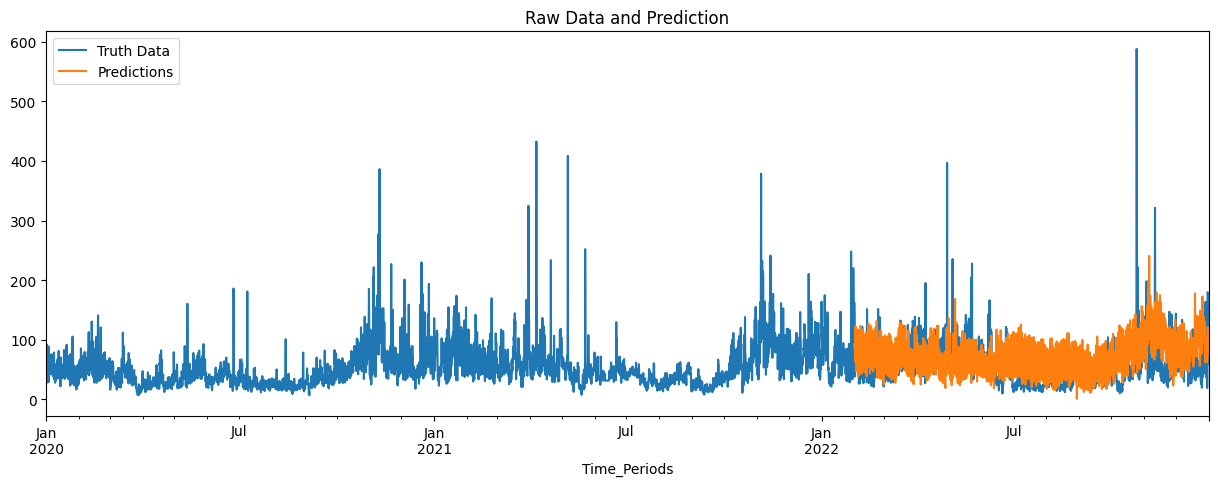

In [ ]:
FEATURES = ['hour', 'dayofweek', 'month',
            'year', 'dayofyear', 'dayofmonth', 'lag1', 'lag2',
            'lag3']
TARGET = 'PM2_5'

cities = set(df_1.City)


#Training and saving models for each city
#The models here are trained and tested only for demonstration
for i in cities:
  print('Training started for ',i,' -------------------')

  temp = df_1[df_1['City']==i]

  train = temp.loc[temp.index < '02-01-2022']
  x_train = train[FEATURES]
  y_train = train[TARGET]

  test = temp.loc[temp.index >= '02-01-2022']
  x_test = test[FEATURES]
  y_test = test[TARGET]

  reg = xgb.XGBRegressor(
                        booster='gbtree',    
                        n_estimators=500,
                        objective='reg:linear',
                        max_depth=4,
                        learning_rate=0.05)
  
  reg.fit(x_train, y_train,
          eval_set=[(x_test, y_test)],
          verbose=100)
  
  prediction_plot(temp,reg,x_test,y_test)

  del reg, x_train, y_train , x_test , y_test

In [ ]:
np.mean(res)

0.9525633960345696

In [ ]:
#Models trained on whole dataset for each city
for i in cities:
  print('Training started for ',i,' --------')

  temp = df_1[df_1['City']==i]
  x_all = temp[FEATURES]
  y_all = temp[TARGET]

  test = temp.loc[temp.index >= '02-01-2022']
  x_test = test[FEATURES]
  y_test = test[TARGET]

  reg = xgb.XGBRegressor(
                        booster='gbtree',    
                        n_estimators=500,
                        objective='reg:linear',
                        max_depth=4,
                        learning_rate=0.05)
  reg.fit(x_all, y_all,
          eval_set=[(x_test, y_test)],
          verbose=100)
  
  #saving the models
  filename = i+'.json'
  reg.save_model(filename)

  del reg, x_all , y_all

##Dart Regression model - not completed
convert in multiple timeseries

In [ ]:
df_1 = df_1.drop(['NH3','Ozone','SR','WS','WD','RF','RF','TOT_RF'],axis=1)

In [ ]:
pip install darts

In [ ]:
import darts
import sklearn
from darts import TimeSeries
from darts.models import RegressionModel
from sklearn.linear_model import LinearRegression

In [ ]:
s = set(df_1.City)
s = list(s)
mp = {}
for i,x in enumerate(s):
  mp[x] = i+1

In [ ]:
df_1['City_nominal']  = df_1.City.map(mp)

In [ ]:
y_all = TimeSeries.from_group_dataframe(df_1,
                                   group_cols='City_nominal',
                                   time_col='Time_Periods',
                                   value_cols=['PM2_5'])

In [ ]:
future_cov_all = TimeSeries.from_group_dataframe(df_1,
                                   group_cols='City_nominal',
                                   time_col='Time_Periods',
                                   value_cols=[ 'NO', 'NO2', 'NOx', 'SO2', 'CO', 'Benzene', 'AT',
       'Population_2021', 'Latitude', 'Longitude', 'Total_Length_Roads_2019',
       'Length_National_Highways_2022', 'Railway_Route_2021',
       'Forest_Cover_2021', 'Number_Factories_2020',
       'Installed_Capacity_Power_2022_MW', 'Death_Rate_2020',
       'vehicles_CNG', 'vehicles_DP'])

In [ ]:
model = RegressionModel(lags = [-1,-2,-12] , lags_future_covariates=[10] , model = LinearRegression())

In [ ]:
model.fit(y_all, future_covariates = future_cov_all)

In [ ]:
y_pred = model.predict(n=0, series = y_all[:1] ,future_covariates = future_cov_all[:2])

#Simple submission

In [ ]:
#future dataset for dates in range 2023-01-01 to 2023-01-03
future = pd.date_range('2023-01-01','2023-01-03 20:00:00', freq='4h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df_1['isFuture'] = False
df_and_future = pd.concat([df_1, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

In [ ]:
sorted(cities)
#submission table
submission_pred = pd.DataFrame(columns=['prediction','City'])
submission_pred.index = pd.to_datetime(submission_pred.index)
#calling models city wise
for i in cities:
  model_name = i+'.json'
  t = pd.DataFrame()
  reg_new = xgb.XGBRegressor()
  reg_new.load_model(model_name)
  t['prediction'] = reg_new.predict(future_w_features[FEATURES])
  t['City']  = pd.Series([i]*18)
  t.index = future_w_features.index
  submission_pred = pd.concat([t, submission_pred])
  

In [ ]:
submission_pred.to_csv('submission.csv')